# Liquid Foam Stress Relaxation

Fit liquid foam relaxation data.

**Data:** examples/data/pyRheo/shaving_foam/stressrelaxation_liquidfoam_data.csv


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fractional_maxwell_model import FractionalMaxwellModel
from rheojax.models.generalized_maxwell import GeneralizedMaxwell
from rheojax.pipeline.base import Pipeline

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)

def load_tab_file(path):
    df = pd.read_csv(path, sep='	')
    df.columns = df.columns.str.strip()
    df = df.dropna()
    df.iloc[:,0] = pd.to_numeric(df.iloc[:,0], errors='coerce')
    df.iloc[:,1] = pd.to_numeric(df.iloc[:,1], errors='coerce')
    df = df.dropna()
    return df
import arviz as az


INFO:2025-12-06 20:07:52,539:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Loading rheojax version 0.4.0


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


Found 'auto' as default backend, checking available backends


Matplotlib is available, defining as default backend


arviz_base available, exposing its functions as part of arviz.preview


arviz_stats available, exposing its functions as part of arviz.preview


arviz_plots available, exposing its functions as part of arviz.preview


## Load relaxation data

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'pyRheo' / 'shaving_foam'
df = load_tab_file(DATA_DIR / 'stressrelaxation_liquidfoam_data.csv')
t = df.iloc[:,0].to_numpy()
G = df.iloc[:,1].to_numpy()


## Fit relaxation models

In [4]:
gm = GeneralizedMaxwell(n_modes=4, modulus_type='tensile')
gm.fit(t, G, test_mode='relaxation', use_log_residuals=True)
gm_pred = gm.predict(t)
gm_r2 = gm.score(t, G)

fm = FractionalMaxwellModel()
fm.fit(t, G, test_mode='relaxation', use_log_residuals=True)
fm_pred = fm.predict(t, test_mode='relaxation')
fm_r2 = r2_complex(G, fm_pred)

print({'gm_r2': gm_r2, 'fm_r2': fm_r2})


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.228123s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=2.011973e+02 | time=1.228s | final_gradient_norm=3.448524376493388


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.326785s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=2.011973e+02 | time=0.327s | final_gradient_norm=3.448524376493388


Starting least squares optimization | {'method': 'trf', 'n_params': 7, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.763220s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=12 | final_cost=3.853320e+02 | time=0.763s | final_gradient_norm=0.20374884693319067


Element minimization: early termination at n_modes=3 (R²=0.999674 < threshold=0.999745)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


[WARNING] Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Timer: optimization took 1.204408s


Convergence: reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=9.610186e+05 | time=1.204s | final_gradient_norm=nan


NLSQ hit inner iteration limit; retrying with SciPy least_squares for stability.


{'gm_r2': 0.9998299348748985, 'fm_r2': -19635.53943933752}


## Plot relaxation fits

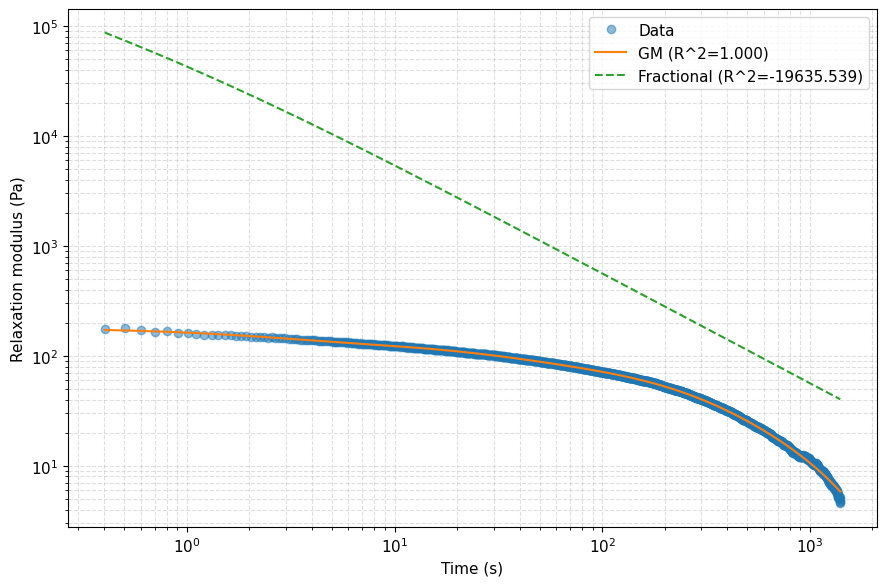

In [5]:
fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(t, G, 'o', label='Data', alpha=0.5)
ax.loglog(t, gm_pred, '-', label=f'GM (R^2={gm_r2:.3f})')
ax.loglog(t, fm_pred, '--', label=f'Fractional (R^2={fm_r2:.3f})')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Relaxation modulus (Pa)')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.341238s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=2.011973e+02 | time=0.341s | final_gradient_norm=3.448524376493388


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.421903s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=2.011973e+02 | time=0.422s | final_gradient_norm=3.448524376493388


Starting least squares optimization | {'method': 'trf', 'n_params': 7, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.226530s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=12 | final_cost=3.853320e+02 | time=0.227s | final_gradient_norm=0.20374884693319067


Element minimization: early termination at n_modes=3 (R²=0.999674 < threshold=0.999745)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


[WARNING] Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Timer: optimization took 0.651496s


Convergence: reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=9.610186e+05 | time=0.651s | final_gradient_norm=nan


NLSQ hit inner iteration limit; retrying with SciPy least_squares for stability.


Model ranking (R²): [('gm', 1.0), ('fm', -19635.539)]


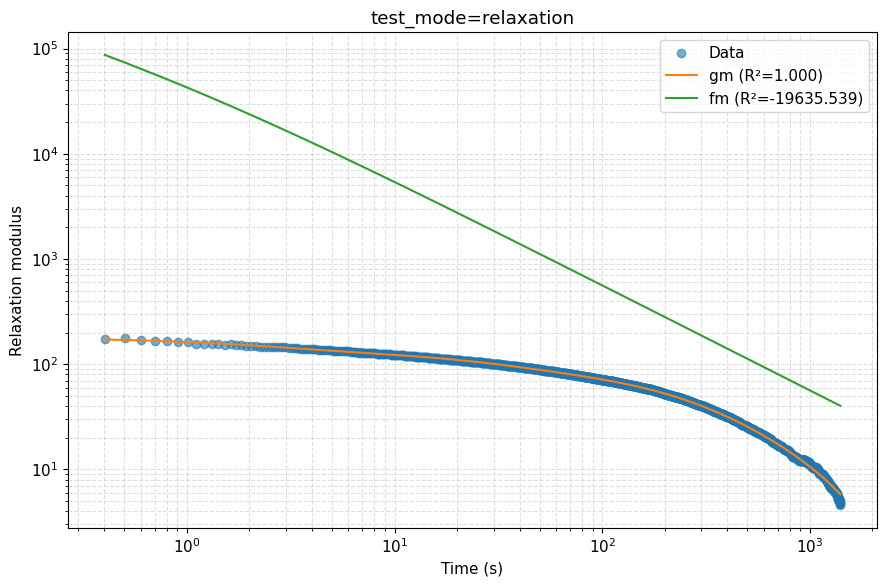

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<52:27,  1.27it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|▏         | 52/4000 [00:00<00:51, 76.99it/s, 767 steps of size 2.97e-04. acc. prob=0.71]

warmup:   2%|▏         | 77/4000 [00:01<00:51, 76.75it/s, 255 steps of size 5.29e-04. acc. prob=0.74]

warmup:   2%|▏         | 95/4000 [00:01<00:52, 74.92it/s, 127 steps of size 2.77e-04. acc. prob=0.74]

warmup:   3%|▎         | 109/4000 [00:01<01:02, 62.41it/s, 3 steps of size 2.33e-03. acc. prob=0.75] 

warmup:   3%|▎         | 119/4000 [00:02<01:08, 56.88it/s, 1023 steps of size 7.00e-03. acc. prob=0.76]

warmup:   3%|▎         | 127/4000 [00:02<01:07, 57.35it/s, 191 steps of size 1.38e-02. acc. prob=0.76] 

warmup:   3%|▎         | 135/4000 [00:02<01:13, 52.85it/s, 3 steps of size 2.91e-03. acc. prob=0.76]  

warmup:   4%|▎         | 142/4000 [00:02<01:20, 47.79it/s, 1023 steps of size 1.18e-02. acc. prob=0.76]

warmup:   4%|▍         | 150/4000 [00:02<01:14, 52.02it/s, 511 steps of size 1.67e-02. acc. prob=0.77] 

warmup:   4%|▍         | 160/4000 [00:02<01:03, 60.88it/s, 127 steps of size 1.51e-02. acc. prob=0.76]

warmup:   4%|▍         | 168/4000 [00:02<01:03, 60.30it/s, 207 steps of size 1.31e-02. acc. prob=0.77]

warmup:   4%|▍         | 177/4000 [00:03<00:57, 66.27it/s, 1023 steps of size 5.75e-03. acc. prob=0.77]

warmup:   5%|▍         | 185/4000 [00:03<00:59, 64.15it/s, 127 steps of size 2.56e-02. acc. prob=0.77] 

warmup:   5%|▍         | 195/4000 [00:03<00:54, 70.07it/s, 511 steps of size 7.02e-03. acc. prob=0.77]

warmup:   5%|▌         | 203/4000 [00:03<00:56, 66.93it/s, 511 steps of size 1.27e-02. acc. prob=0.77]

warmup:   5%|▌         | 213/4000 [00:03<00:50, 74.71it/s, 127 steps of size 2.81e-02. acc. prob=0.77]

warmup:   6%|▌         | 225/4000 [00:03<00:43, 86.27it/s, 255 steps of size 2.69e-02. acc. prob=0.77]

warmup:   6%|▌         | 235/4000 [00:03<00:49, 76.31it/s, 511 steps of size 1.26e-02. acc. prob=0.77]

warmup:   6%|▌         | 247/4000 [00:03<00:43, 87.04it/s, 255 steps of size 2.28e-02. acc. prob=0.78]

warmup:   6%|▋         | 257/4000 [00:04<00:43, 86.61it/s, 255 steps of size 2.22e-02. acc. prob=0.77]

warmup:   7%|▋         | 269/4000 [00:04<00:39, 93.47it/s, 383 steps of size 4.77e-03. acc. prob=0.77]

warmup:   7%|▋         | 279/4000 [00:04<00:42, 87.25it/s, 9 steps of size 4.28e-03. acc. prob=0.77]  

warmup:   7%|▋         | 290/4000 [00:04<00:39, 93.12it/s, 3 steps of size 4.88e-03. acc. prob=0.77]

warmup:   8%|▊         | 300/4000 [00:04<00:39, 93.25it/s, 255 steps of size 1.32e-02. acc. prob=0.78]

warmup:   8%|▊         | 310/4000 [00:04<00:38, 95.06it/s, 4 steps of size 5.81e-03. acc. prob=0.78]  

warmup:   8%|▊         | 320/4000 [00:04<00:39, 92.87it/s, 255 steps of size 1.61e-02. acc. prob=0.78]

warmup:   8%|▊         | 330/4000 [00:04<00:42, 85.93it/s, 511 steps of size 1.64e-02. acc. prob=0.78]

warmup:   9%|▊         | 345/4000 [00:04<00:35, 102.31it/s, 255 steps of size 1.63e-02. acc. prob=0.78]

warmup:   9%|▉         | 356/4000 [00:05<00:35, 102.71it/s, 8 steps of size 1.15e-02. acc. prob=0.78]  

warmup:   9%|▉         | 368/4000 [00:05<00:34, 105.59it/s, 255 steps of size 1.49e-02. acc. prob=0.78]

warmup:  10%|▉         | 380/4000 [00:05<00:33, 109.48it/s, 255 steps of size 1.28e-02. acc. prob=0.78]

warmup:  10%|▉         | 394/4000 [00:05<00:31, 116.00it/s, 255 steps of size 1.72e-02. acc. prob=0.78]

warmup:  10%|█         | 406/4000 [00:05<00:33, 106.67it/s, 511 steps of size 2.31e-02. acc. prob=0.78]

warmup:  10%|█         | 420/4000 [00:05<00:31, 113.06it/s, 255 steps of size 1.23e-02. acc. prob=0.78]

warmup:  11%|█         | 432/4000 [00:05<00:31, 114.12it/s, 319 steps of size 1.91e-02. acc. prob=0.78]

warmup:  11%|█         | 444/4000 [00:05<00:30, 115.06it/s, 255 steps of size 1.96e-02. acc. prob=0.78]

warmup:  11%|█▏        | 456/4000 [00:05<00:32, 108.49it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  12%|█▏        | 467/4000 [00:06<00:44, 79.76it/s, 1023 steps of size 9.74e-03. acc. prob=0.78]

warmup:  12%|█▏        | 478/4000 [00:06<00:43, 80.13it/s, 1023 steps of size 6.46e-03. acc. prob=0.78]

warmup:  12%|█▏        | 489/4000 [00:06<00:41, 84.11it/s, 511 steps of size 1.50e-02. acc. prob=0.78] 

warmup:  13%|█▎        | 501/4000 [00:06<00:38, 91.59it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  13%|█▎        | 512/4000 [00:06<00:36, 94.79it/s, 511 steps of size 1.47e-02. acc. prob=0.78]

warmup:  13%|█▎        | 522/4000 [00:06<00:36, 95.40it/s, 198 steps of size 1.28e-02. acc. prob=0.78]

warmup:  13%|█▎        | 532/4000 [00:06<00:37, 92.40it/s, 127 steps of size 2.04e-02. acc. prob=0.78]

warmup:  14%|█▎        | 545/4000 [00:06<00:33, 102.47it/s, 255 steps of size 1.84e-02. acc. prob=0.78]

warmup:  14%|█▍        | 562/4000 [00:07<00:28, 119.42it/s, 255 steps of size 1.97e-02. acc. prob=0.78]

warmup:  14%|█▍        | 577/4000 [00:07<00:27, 126.42it/s, 127 steps of size 2.32e-02. acc. prob=0.78]

warmup:  15%|█▍        | 590/4000 [00:07<00:27, 125.90it/s, 255 steps of size 1.43e-02. acc. prob=0.78]

warmup:  15%|█▌        | 603/4000 [15:24<19:30:38, 20.68s/it, 255 steps of size 2.41e-02. acc. prob=0.78]

warmup:  15%|█▌        | 615/4000 [15:25<14:01:41, 14.92s/it, 255 steps of size 1.70e-02. acc. prob=0.78]

warmup:  16%|█▌        | 628/4000 [15:25<9:46:01, 10.43s/it, 543 steps of size 1.05e-02. acc. prob=0.78] 

warmup:  16%|█▌        | 640/4000 [15:25<6:58:06,  7.47s/it, 127 steps of size 1.57e-02. acc. prob=0.78]

warmup:  16%|█▋        | 652/4000 [15:25<4:56:25,  5.31s/it, 127 steps of size 1.40e-02. acc. prob=0.79]

warmup:  17%|█▋        | 664/4000 [15:25<3:29:14,  3.76s/it, 255 steps of size 1.49e-02. acc. prob=0.79]

warmup:  17%|█▋        | 675/4000 [15:25<2:30:59,  2.72s/it, 255 steps of size 2.17e-02. acc. prob=0.79]

warmup:  17%|█▋        | 688/4000 [15:25<1:42:40,  1.86s/it, 511 steps of size 1.67e-02. acc. prob=0.79]

warmup:  18%|█▊        | 701/4000 [15:25<1:10:25,  1.28s/it, 63 steps of size 2.35e-02. acc. prob=0.79] 

warmup:  18%|█▊        | 713/4000 [15:25<49:50,  1.10it/s, 255 steps of size 1.29e-02. acc. prob=0.79] 

warmup:  18%|█▊        | 726/4000 [15:26<34:19,  1.59it/s, 191 steps of size 1.96e-02. acc. prob=0.79]

warmup:  18%|█▊        | 738/4000 [15:26<24:25,  2.23it/s, 63 steps of size 1.45e-02. acc. prob=0.79] 

warmup:  19%|█▉        | 752/4000 [15:26<16:30,  3.28it/s, 255 steps of size 1.59e-02. acc. prob=0.79]

warmup:  19%|█▉        | 764/4000 [15:26<11:54,  4.53it/s, 127 steps of size 1.39e-02. acc. prob=0.79]

warmup:  20%|█▉        | 781/4000 [15:26<07:38,  7.02it/s, 511 steps of size 1.44e-02. acc. prob=0.79]

warmup:  20%|█▉        | 794/4000 [15:26<05:34,  9.59it/s, 255 steps of size 2.00e-02. acc. prob=0.79]

warmup:  20%|██        | 806/4000 [15:26<04:10, 12.76it/s, 255 steps of size 1.37e-02. acc. prob=0.79]

warmup:  20%|██        | 818/4000 [15:26<03:07, 16.97it/s, 255 steps of size 1.16e-02. acc. prob=0.79]

warmup:  21%|██        | 830/4000 [15:27<02:23, 22.16it/s, 63 steps of size 1.94e-02. acc. prob=0.79] 

warmup:  21%|██        | 841/4000 [15:27<01:54, 27.66it/s, 191 steps of size 1.46e-02. acc. prob=0.79]

warmup:  21%|██▏       | 854/4000 [15:27<01:26, 36.54it/s, 255 steps of size 1.18e-02. acc. prob=0.79]

warmup:  22%|██▏       | 866/4000 [15:27<01:08, 45.86it/s, 255 steps of size 1.59e-02. acc. prob=0.79]

warmup:  22%|██▏       | 879/4000 [15:27<00:54, 57.15it/s, 127 steps of size 1.12e-02. acc. prob=0.79]

warmup:  22%|██▏       | 893/4000 [15:27<00:43, 70.68it/s, 127 steps of size 2.02e-02. acc. prob=0.79]

warmup:  23%|██▎       | 906/4000 [15:27<00:40, 75.91it/s, 255 steps of size 2.07e-02. acc. prob=0.79]

warmup:  23%|██▎       | 918/4000 [15:27<00:36, 83.59it/s, 511 steps of size 1.36e-02. acc. prob=0.79]

warmup:  23%|██▎       | 931/4000 [15:27<00:32, 93.70it/s, 255 steps of size 1.45e-02. acc. prob=0.79]

warmup:  24%|██▎       | 945/4000 [15:28<00:29, 103.69it/s, 255 steps of size 1.60e-02. acc. prob=0.79]

warmup:  24%|██▍       | 958/4000 [15:28<00:27, 109.21it/s, 255 steps of size 1.90e-02. acc. prob=0.79]

warmup:  24%|██▍       | 971/4000 [15:28<00:34, 86.78it/s, 255 steps of size 1.78e-02. acc. prob=0.79] 

warmup:  25%|██▍       | 982/4000 [15:28<00:34, 86.86it/s, 127 steps of size 2.74e-02. acc. prob=0.79]

warmup:  25%|██▍       | 992/4000 [15:28<00:37, 80.62it/s, 5 steps of size 3.57e-03. acc. prob=0.79]  

sample:  25%|██▌       | 1001/4000 [15:28<00:39, 76.73it/s, 511 steps of size 1.22e-02. acc. prob=0.98]

sample:  25%|██▌       | 1010/4000 [15:28<00:39, 75.34it/s, 255 steps of size 1.22e-02. acc. prob=0.97]

sample:  25%|██▌       | 1018/4000 [15:29<00:41, 72.69it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  26%|██▌       | 1026/4000 [15:29<00:41, 71.50it/s, 511 steps of size 1.22e-02. acc. prob=0.96]

sample:  26%|██▌       | 1037/4000 [15:29<00:36, 80.10it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  26%|██▌       | 1046/4000 [15:29<00:36, 80.58it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  26%|██▋       | 1055/4000 [15:29<00:36, 81.36it/s, 255 steps of size 1.22e-02. acc. prob=0.95]

sample:  27%|██▋       | 1064/4000 [15:29<00:36, 79.79it/s, 255 steps of size 1.22e-02. acc. prob=0.95]

sample:  27%|██▋       | 1074/4000 [15:29<00:35, 83.08it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  27%|██▋       | 1083/4000 [15:29<00:36, 79.31it/s, 191 steps of size 1.22e-02. acc. prob=0.94]

sample:  27%|██▋       | 1093/4000 [15:29<00:34, 83.56it/s, 255 steps of size 1.22e-02. acc. prob=0.93]

sample:  28%|██▊       | 1102/4000 [15:30<00:34, 83.80it/s, 383 steps of size 1.22e-02. acc. prob=0.94]

sample:  28%|██▊       | 1111/4000 [15:30<00:35, 80.81it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  28%|██▊       | 1120/4000 [15:30<00:35, 80.32it/s, 191 steps of size 1.22e-02. acc. prob=0.93]

sample:  28%|██▊       | 1131/4000 [15:30<00:33, 86.53it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  28%|██▊       | 1140/4000 [15:30<00:35, 79.85it/s, 511 steps of size 1.22e-02. acc. prob=0.93]

sample:  29%|██▊       | 1149/4000 [15:30<00:37, 75.48it/s, 255 steps of size 1.22e-02. acc. prob=0.93]

sample:  29%|██▉       | 1157/4000 [15:30<00:39, 71.77it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  29%|██▉       | 1166/4000 [15:30<00:37, 74.84it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  29%|██▉       | 1174/4000 [15:30<00:37, 74.77it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  30%|██▉       | 1183/4000 [15:31<00:37, 75.79it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  30%|██▉       | 1191/4000 [15:31<00:36, 76.48it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  30%|███       | 1200/4000 [15:31<00:36, 76.62it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  30%|███       | 1209/4000 [15:31<00:35, 78.41it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  30%|███       | 1218/4000 [15:31<00:35, 78.59it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  31%|███       | 1227/4000 [15:31<00:34, 80.28it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  31%|███       | 1236/4000 [15:31<00:35, 76.89it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  31%|███       | 1245/4000 [15:31<00:35, 78.40it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  31%|███▏      | 1254/4000 [15:31<00:34, 78.85it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  32%|███▏      | 1262/4000 [15:32<00:35, 77.39it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  32%|███▏      | 1270/4000 [15:32<00:35, 76.64it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  32%|███▏      | 1278/4000 [15:32<00:35, 76.93it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  32%|███▏      | 1287/4000 [15:32<00:34, 79.78it/s, 103 steps of size 1.22e-02. acc. prob=0.94]

sample:  32%|███▏      | 1295/4000 [15:32<00:35, 75.91it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  33%|███▎      | 1309/4000 [15:32<00:28, 93.77it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  33%|███▎      | 1319/4000 [15:32<00:28, 93.08it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  33%|███▎      | 1329/4000 [15:32<00:29, 90.58it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  33%|███▎      | 1339/4000 [15:32<00:29, 89.65it/s, 127 steps of size 1.22e-02. acc. prob=0.94]

sample:  34%|███▎      | 1349/4000 [15:33<00:30, 85.76it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  34%|███▍      | 1358/4000 [15:33<00:31, 84.39it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  34%|███▍      | 1367/4000 [15:33<00:37, 70.13it/s, 383 steps of size 1.22e-02. acc. prob=0.94]

sample:  34%|███▍      | 1376/4000 [15:33<00:36, 71.91it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  35%|███▍      | 1384/4000 [15:33<00:36, 70.77it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  35%|███▍      | 1392/4000 [15:33<00:37, 70.19it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  35%|███▌      | 1401/4000 [15:33<00:34, 74.42it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  35%|███▌      | 1412/4000 [15:33<00:32, 79.71it/s, 1023 steps of size 1.22e-02. acc. prob=0.94]

sample:  36%|███▌      | 1421/4000 [15:34<00:34, 73.92it/s, 511 steps of size 1.22e-02. acc. prob=0.94] 

sample:  36%|███▌      | 1431/4000 [15:34<00:32, 79.61it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  36%|███▌      | 1441/4000 [15:34<00:30, 82.92it/s, 383 steps of size 1.22e-02. acc. prob=0.94]

sample:  36%|███▋      | 1450/4000 [15:34<00:32, 79.56it/s, 63 steps of size 1.22e-02. acc. prob=0.94] 

sample:  36%|███▋      | 1460/4000 [15:34<00:31, 81.00it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  37%|███▋      | 1469/4000 [15:34<00:31, 79.34it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  37%|███▋      | 1479/4000 [15:34<00:30, 83.37it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  37%|███▋      | 1488/4000 [15:34<00:30, 83.14it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  37%|███▋      | 1499/4000 [15:35<00:28, 88.26it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  38%|███▊      | 1509/4000 [15:35<00:27, 91.26it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  38%|███▊      | 1519/4000 [15:35<00:28, 87.18it/s, 127 steps of size 1.22e-02. acc. prob=0.94]

sample:  38%|███▊      | 1528/4000 [15:35<00:29, 84.97it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  38%|███▊      | 1537/4000 [15:35<00:31, 79.26it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  39%|███▊      | 1546/4000 [15:35<00:31, 76.85it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  39%|███▉      | 1554/4000 [15:35<00:32, 76.22it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  39%|███▉      | 1562/4000 [15:35<00:31, 76.33it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  39%|███▉      | 1570/4000 [15:35<00:33, 71.84it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  39%|███▉      | 1578/4000 [15:36<00:33, 73.24it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  40%|███▉      | 1587/4000 [15:36<00:31, 76.70it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  40%|███▉      | 1596/4000 [15:36<00:31, 76.81it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  40%|████      | 1605/4000 [15:36<00:30, 79.40it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  40%|████      | 1615/4000 [15:36<00:28, 83.61it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  41%|████      | 1624/4000 [15:36<00:31, 75.26it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  41%|████      | 1634/4000 [15:36<00:29, 80.19it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  41%|████      | 1643/4000 [15:36<00:30, 77.98it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  41%|████▏     | 1652/4000 [15:36<00:29, 79.28it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  42%|████▏     | 1662/4000 [15:37<00:27, 83.55it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  42%|████▏     | 1671/4000 [15:37<00:29, 79.15it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  42%|████▏     | 1680/4000 [15:37<00:29, 78.16it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  42%|████▏     | 1690/4000 [15:37<00:27, 83.03it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  42%|████▏     | 1699/4000 [15:37<00:28, 80.04it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  43%|████▎     | 1708/4000 [15:37<00:29, 77.11it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  43%|████▎     | 1716/4000 [15:37<00:30, 74.37it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  43%|████▎     | 1726/4000 [15:37<00:28, 81.05it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  43%|████▎     | 1735/4000 [15:38<00:27, 82.15it/s, 127 steps of size 1.22e-02. acc. prob=0.94]

sample:  44%|████▎     | 1744/4000 [15:38<00:27, 83.43it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  44%|████▍     | 1753/4000 [15:38<00:26, 83.44it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  44%|████▍     | 1762/4000 [15:38<00:26, 83.03it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  44%|████▍     | 1771/4000 [15:38<00:27, 81.45it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  45%|████▍     | 1781/4000 [15:38<00:26, 84.98it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  45%|████▍     | 1790/4000 [15:38<00:27, 80.62it/s, 191 steps of size 1.22e-02. acc. prob=0.94]

sample:  45%|████▍     | 1799/4000 [15:38<00:26, 82.35it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  45%|████▌     | 1808/4000 [15:38<00:26, 83.35it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  45%|████▌     | 1817/4000 [15:38<00:26, 81.97it/s, 383 steps of size 1.22e-02. acc. prob=0.94]

sample:  46%|████▌     | 1826/4000 [15:39<00:29, 74.88it/s, 127 steps of size 1.22e-02. acc. prob=0.94]

sample:  46%|████▌     | 1835/4000 [15:39<00:28, 77.15it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  46%|████▌     | 1845/4000 [15:39<00:26, 80.24it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  46%|████▋     | 1854/4000 [15:39<00:28, 74.68it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  47%|████▋     | 1863/4000 [15:39<00:27, 78.01it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  47%|████▋     | 1871/4000 [15:39<00:28, 74.30it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  47%|████▋     | 1879/4000 [15:39<00:28, 73.50it/s, 127 steps of size 1.22e-02. acc. prob=0.94]

sample:  47%|████▋     | 1889/4000 [15:39<00:26, 78.70it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  47%|████▋     | 1898/4000 [15:40<00:26, 80.71it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  48%|████▊     | 1909/4000 [15:40<00:24, 87.03it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  48%|████▊     | 1918/4000 [15:40<00:26, 79.86it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  48%|████▊     | 1928/4000 [15:40<00:24, 84.11it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  48%|████▊     | 1937/4000 [15:40<00:26, 79.34it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  49%|████▊     | 1947/4000 [15:40<00:24, 84.09it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  49%|████▉     | 1956/4000 [15:40<00:23, 85.26it/s, 383 steps of size 1.22e-02. acc. prob=0.94]

sample:  49%|████▉     | 1965/4000 [15:40<00:23, 86.42it/s, 127 steps of size 1.22e-02. acc. prob=0.94]

sample:  49%|████▉     | 1975/4000 [15:40<00:22, 88.15it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  50%|████▉     | 1984/4000 [15:41<00:23, 85.89it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  50%|████▉     | 1993/4000 [15:41<00:24, 82.09it/s, 639 steps of size 1.22e-02. acc. prob=0.94]

sample:  50%|█████     | 2002/4000 [15:41<00:23, 83.32it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  50%|█████     | 2012/4000 [15:41<00:22, 87.79it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  51%|█████     | 2021/4000 [15:41<00:23, 85.87it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  51%|█████     | 2030/4000 [15:41<00:23, 84.49it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  51%|█████     | 2041/4000 [15:41<00:21, 90.06it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  51%|█████▏    | 2051/4000 [15:41<00:21, 90.79it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  52%|█████▏    | 2061/4000 [15:41<00:21, 92.19it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  52%|█████▏    | 2071/4000 [15:42<00:23, 82.47it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  52%|█████▏    | 2080/4000 [15:42<00:24, 79.09it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  52%|█████▏    | 2089/4000 [15:42<00:25, 74.50it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  52%|█████▏    | 2097/4000 [15:42<00:25, 75.10it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  53%|█████▎    | 2105/4000 [15:42<00:26, 71.35it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  53%|█████▎    | 2113/4000 [15:42<00:26, 72.14it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  53%|█████▎    | 2123/4000 [15:42<00:24, 77.12it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  53%|█████▎    | 2131/4000 [15:42<00:24, 75.42it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  54%|█████▎    | 2140/4000 [15:43<00:23, 77.54it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  54%|█████▍    | 2152/4000 [15:43<00:21, 87.19it/s, 383 steps of size 1.22e-02. acc. prob=0.94]

sample:  54%|█████▍    | 2163/4000 [15:43<00:19, 92.23it/s, 127 steps of size 1.22e-02. acc. prob=0.94]

sample:  54%|█████▍    | 2173/4000 [15:43<00:20, 87.49it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  55%|█████▍    | 2184/4000 [15:43<00:19, 91.91it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  55%|█████▍    | 2194/4000 [15:43<00:21, 85.29it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  55%|█████▌    | 2204/4000 [15:43<00:20, 88.59it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  55%|█████▌    | 2214/4000 [15:43<00:19, 89.63it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  56%|█████▌    | 2224/4000 [15:43<00:20, 86.46it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  56%|█████▌    | 2233/4000 [15:44<00:21, 82.79it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  56%|█████▌    | 2243/4000 [15:44<00:20, 84.54it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  56%|█████▋    | 2253/4000 [15:44<00:20, 86.58it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  57%|█████▋    | 2262/4000 [15:44<00:20, 83.08it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  57%|█████▋    | 2271/4000 [15:44<00:20, 84.56it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  57%|█████▋    | 2281/4000 [15:44<00:19, 87.41it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  57%|█████▋    | 2291/4000 [15:44<00:19, 87.54it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  58%|█████▊    | 2301/4000 [15:44<00:18, 90.74it/s, 287 steps of size 1.22e-02. acc. prob=0.94]

sample:  58%|█████▊    | 2311/4000 [15:44<00:19, 87.18it/s, 415 steps of size 1.22e-02. acc. prob=0.94]

sample:  58%|█████▊    | 2320/4000 [15:45<00:20, 83.81it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  58%|█████▊    | 2329/4000 [15:45<00:19, 84.88it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  58%|█████▊    | 2339/4000 [15:45<00:19, 84.64it/s, 767 steps of size 1.22e-02. acc. prob=0.94]

sample:  59%|█████▊    | 2348/4000 [15:45<00:19, 85.08it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  59%|█████▉    | 2357/4000 [15:45<00:19, 85.03it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  59%|█████▉    | 2366/4000 [15:45<00:19, 85.47it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  59%|█████▉    | 2377/4000 [15:45<00:17, 90.60it/s, 223 steps of size 1.22e-02. acc. prob=0.94]

sample:  60%|█████▉    | 2387/4000 [15:45<00:18, 88.49it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  60%|█████▉    | 2396/4000 [15:45<00:19, 83.10it/s, 159 steps of size 1.22e-02. acc. prob=0.94]

sample:  60%|██████    | 2406/4000 [15:46<00:18, 87.14it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  60%|██████    | 2415/4000 [15:46<00:18, 84.58it/s, 319 steps of size 1.22e-02. acc. prob=0.94]

sample:  61%|██████    | 2424/4000 [15:46<00:19, 80.35it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  61%|██████    | 2433/4000 [15:46<00:19, 79.83it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  61%|██████    | 2445/4000 [15:46<00:17, 89.89it/s, 127 steps of size 1.22e-02. acc. prob=0.94]

sample:  61%|██████▏   | 2455/4000 [15:46<00:18, 82.57it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  62%|██████▏   | 2465/4000 [15:46<00:17, 86.11it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  62%|██████▏   | 2474/4000 [15:46<00:18, 82.65it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  62%|██████▏   | 2483/4000 [15:46<00:18, 80.61it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  62%|██████▏   | 2492/4000 [15:47<00:18, 80.13it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  63%|██████▎   | 2501/4000 [15:47<00:19, 75.22it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  63%|██████▎   | 2511/4000 [15:47<00:18, 80.52it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  63%|██████▎   | 2520/4000 [15:47<00:18, 79.04it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  63%|██████▎   | 2528/4000 [15:47<00:19, 77.47it/s, 207 steps of size 1.22e-02. acc. prob=0.94]

sample:  63%|██████▎   | 2539/4000 [15:47<00:17, 84.95it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  64%|██████▎   | 2548/4000 [15:47<00:17, 84.51it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  64%|██████▍   | 2557/4000 [15:47<00:17, 84.01it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  64%|██████▍   | 2566/4000 [15:48<00:17, 81.38it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  64%|██████▍   | 2576/4000 [15:48<00:16, 84.57it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  65%|██████▍   | 2585/4000 [15:48<00:17, 81.93it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  65%|██████▍   | 2595/4000 [15:48<00:16, 84.83it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  65%|██████▌   | 2604/4000 [15:48<00:16, 85.85it/s, 127 steps of size 1.22e-02. acc. prob=0.94]

sample:  65%|██████▌   | 2613/4000 [15:48<00:17, 80.54it/s, 639 steps of size 1.22e-02. acc. prob=0.94]

sample:  66%|██████▌   | 2622/4000 [15:48<00:18, 75.74it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  66%|██████▌   | 2630/4000 [15:48<00:17, 76.14it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  66%|██████▌   | 2638/4000 [15:48<00:18, 71.70it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  66%|██████▌   | 2646/4000 [15:49<00:19, 68.88it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  66%|██████▋   | 2656/4000 [15:49<00:17, 76.91it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  67%|██████▋   | 2665/4000 [15:49<00:16, 79.48it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  67%|██████▋   | 2674/4000 [15:49<00:16, 79.15it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  67%|██████▋   | 2684/4000 [15:49<00:15, 83.90it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  67%|██████▋   | 2693/4000 [15:49<00:16, 79.74it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  68%|██████▊   | 2702/4000 [15:49<00:17, 73.14it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  68%|██████▊   | 2712/4000 [15:49<00:16, 76.31it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  68%|██████▊   | 2720/4000 [15:50<00:16, 76.70it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  68%|██████▊   | 2730/4000 [15:50<00:15, 80.98it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  69%|██████▊   | 2741/4000 [15:50<00:14, 84.83it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  69%|██████▉   | 2752/4000 [15:50<00:13, 89.26it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  69%|██████▉   | 2761/4000 [15:50<00:14, 84.28it/s, 639 steps of size 1.22e-02. acc. prob=0.94]

sample:  69%|██████▉   | 2770/4000 [15:50<00:15, 78.19it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  69%|██████▉   | 2778/4000 [15:50<00:16, 74.34it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  70%|██████▉   | 2787/4000 [15:50<00:16, 74.70it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  70%|██████▉   | 2797/4000 [15:50<00:14, 80.58it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  70%|███████   | 2807/4000 [15:51<00:14, 82.50it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  70%|███████   | 2816/4000 [15:51<00:14, 80.97it/s, 319 steps of size 1.22e-02. acc. prob=0.94]

sample:  71%|███████   | 2826/4000 [15:51<00:13, 84.91it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  71%|███████   | 2835/4000 [15:51<00:14, 77.95it/s, 31 steps of size 1.22e-02. acc. prob=0.94] 

sample:  71%|███████   | 2844/4000 [15:51<00:14, 77.35it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  71%|███████▏  | 2853/4000 [15:51<00:14, 80.27it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  72%|███████▏  | 2862/4000 [15:51<00:15, 75.02it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  72%|███████▏  | 2872/4000 [15:51<00:14, 79.99it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  72%|███████▏  | 2881/4000 [15:51<00:14, 79.56it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  72%|███████▏  | 2890/4000 [15:52<00:14, 77.64it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  72%|███████▏  | 2898/4000 [15:52<00:15, 71.20it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  73%|███████▎  | 2906/4000 [15:52<00:14, 73.38it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  73%|███████▎  | 2915/4000 [15:52<00:14, 77.10it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  73%|███████▎  | 2923/4000 [15:52<00:14, 75.46it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  73%|███████▎  | 2931/4000 [15:52<00:14, 75.90it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  73%|███████▎  | 2939/4000 [15:52<00:13, 76.74it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  74%|███████▎  | 2947/4000 [15:52<00:14, 74.86it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  74%|███████▍  | 2955/4000 [15:52<00:13, 75.32it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  74%|███████▍  | 2963/4000 [15:53<00:13, 76.01it/s, 207 steps of size 1.22e-02. acc. prob=0.94]

sample:  74%|███████▍  | 2971/4000 [15:53<00:13, 76.86it/s, 63 steps of size 1.22e-02. acc. prob=0.94] 

sample:  75%|███████▍  | 2981/4000 [15:53<00:12, 82.60it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  75%|███████▍  | 2991/4000 [15:53<00:12, 83.95it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  75%|███████▌  | 3003/4000 [15:53<00:10, 91.90it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  75%|███████▌  | 3013/4000 [15:53<00:11, 85.07it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  76%|███████▌  | 3023/4000 [15:53<00:11, 84.84it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  76%|███████▌  | 3032/4000 [15:53<00:11, 83.18it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  76%|███████▌  | 3041/4000 [15:54<00:12, 77.11it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  76%|███████▋  | 3051/4000 [15:54<00:11, 82.57it/s, 127 steps of size 1.22e-02. acc. prob=0.94]

sample:  76%|███████▋  | 3060/4000 [15:54<00:12, 77.68it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  77%|███████▋  | 3068/4000 [15:54<00:12, 76.52it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  77%|███████▋  | 3076/4000 [15:54<00:12, 71.73it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  77%|███████▋  | 3085/4000 [15:54<00:12, 75.08it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  77%|███████▋  | 3095/4000 [15:54<00:11, 80.68it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  78%|███████▊  | 3104/4000 [15:54<00:11, 79.55it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  78%|███████▊  | 3114/4000 [15:54<00:10, 84.44it/s, 95 steps of size 1.22e-02. acc. prob=0.94] 

sample:  78%|███████▊  | 3125/4000 [15:55<00:09, 89.49it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  78%|███████▊  | 3137/4000 [15:55<00:09, 90.16it/s, 1023 steps of size 1.22e-02. acc. prob=0.94]

sample:  79%|███████▊  | 3147/4000 [15:55<00:09, 87.86it/s, 767 steps of size 1.22e-02. acc. prob=0.94] 

sample:  79%|███████▉  | 3156/4000 [15:55<00:09, 85.99it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  79%|███████▉  | 3165/4000 [15:55<00:10, 82.87it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  79%|███████▉  | 3174/4000 [15:55<00:10, 80.55it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  80%|███████▉  | 3183/4000 [15:55<00:10, 77.58it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  80%|███████▉  | 3191/4000 [15:55<00:10, 77.45it/s, 639 steps of size 1.22e-02. acc. prob=0.94]

sample:  80%|████████  | 3201/4000 [15:55<00:09, 82.56it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  80%|████████  | 3211/4000 [15:56<00:09, 83.74it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  81%|████████  | 3221/4000 [15:56<00:08, 87.05it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  81%|████████  | 3232/4000 [15:56<00:08, 91.14it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  81%|████████  | 3242/4000 [15:56<00:09, 82.73it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  81%|████████▏ | 3251/4000 [15:56<00:09, 80.60it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  82%|████████▏ | 3260/4000 [15:56<00:09, 77.39it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  82%|████████▏ | 3268/4000 [15:56<00:09, 77.81it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  82%|████████▏ | 3277/4000 [15:56<00:09, 79.67it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  82%|████████▏ | 3286/4000 [15:57<00:09, 78.21it/s, 127 steps of size 1.22e-02. acc. prob=0.94]

sample:  82%|████████▏ | 3294/4000 [15:57<00:09, 76.50it/s, 383 steps of size 1.22e-02. acc. prob=0.94]

sample:  83%|████████▎ | 3304/4000 [15:57<00:08, 81.30it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  83%|████████▎ | 3313/4000 [15:57<00:08, 79.69it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  83%|████████▎ | 3323/4000 [15:57<00:08, 83.77it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  83%|████████▎ | 3335/4000 [15:57<00:07, 90.15it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  84%|████████▎ | 3345/4000 [15:57<00:07, 88.82it/s, 127 steps of size 1.22e-02. acc. prob=0.94]

sample:  84%|████████▍ | 3355/4000 [15:57<00:07, 90.27it/s, 271 steps of size 1.22e-02. acc. prob=0.94]

sample:  84%|████████▍ | 3366/4000 [15:57<00:06, 94.14it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  84%|████████▍ | 3376/4000 [15:58<00:07, 88.45it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  85%|████████▍ | 3385/4000 [15:58<00:07, 81.97it/s, 63 steps of size 1.22e-02. acc. prob=0.94] 

sample:  85%|████████▍ | 3395/4000 [15:58<00:07, 86.19it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  85%|████████▌ | 3404/4000 [15:58<00:07, 82.50it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  85%|████████▌ | 3413/4000 [15:58<00:07, 75.82it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  86%|████████▌ | 3422/4000 [15:58<00:07, 77.58it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  86%|████████▌ | 3432/4000 [15:58<00:06, 82.69it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  86%|████████▌ | 3441/4000 [15:58<00:06, 83.63it/s, 127 steps of size 1.22e-02. acc. prob=0.94]

sample:  86%|████████▋ | 3452/4000 [15:58<00:06, 89.06it/s, 447 steps of size 1.22e-02. acc. prob=0.94]

sample:  87%|████████▋ | 3461/4000 [15:59<00:06, 86.37it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  87%|████████▋ | 3470/4000 [15:59<00:06, 81.60it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  87%|████████▋ | 3479/4000 [15:59<00:06, 81.74it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  87%|████████▋ | 3488/4000 [15:59<00:06, 79.47it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  88%|████████▊ | 3500/4000 [15:59<00:05, 89.12it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  88%|████████▊ | 3510/4000 [15:59<00:06, 77.49it/s, 767 steps of size 1.22e-02. acc. prob=0.94]

sample:  88%|████████▊ | 3519/4000 [15:59<00:06, 79.08it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  88%|████████▊ | 3528/4000 [15:59<00:06, 75.62it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  88%|████████▊ | 3538/4000 [16:00<00:05, 80.75it/s, 319 steps of size 1.22e-02. acc. prob=0.94]

sample:  89%|████████▊ | 3547/4000 [16:00<00:05, 81.22it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  89%|████████▉ | 3556/4000 [16:00<00:05, 80.06it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  89%|████████▉ | 3565/4000 [16:00<00:05, 73.14it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  89%|████████▉ | 3577/4000 [16:00<00:05, 83.08it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  90%|████████▉ | 3586/4000 [16:00<00:05, 79.16it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  90%|████████▉ | 3595/4000 [16:00<00:05, 77.43it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  90%|█████████ | 3604/4000 [16:00<00:04, 80.38it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  90%|█████████ | 3613/4000 [16:01<00:04, 78.14it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  91%|█████████ | 3621/4000 [16:01<00:04, 76.77it/s, 499 steps of size 1.22e-02. acc. prob=0.94]

sample:  91%|█████████ | 3629/4000 [16:01<00:04, 76.96it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  91%|█████████ | 3637/4000 [16:01<00:05, 71.46it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  91%|█████████ | 3646/4000 [16:01<00:04, 75.58it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  91%|█████████▏| 3654/4000 [16:01<00:04, 74.23it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  92%|█████████▏| 3663/4000 [16:01<00:04, 76.69it/s, 767 steps of size 1.22e-02. acc. prob=0.94]

sample:  92%|█████████▏| 3671/4000 [16:01<00:04, 74.32it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  92%|█████████▏| 3680/4000 [16:01<00:04, 77.81it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  92%|█████████▏| 3689/4000 [16:02<00:03, 80.42it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  92%|█████████▏| 3699/4000 [16:02<00:03, 81.46it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  93%|█████████▎| 3708/4000 [16:02<00:03, 77.39it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  93%|█████████▎| 3716/4000 [16:02<00:04, 70.86it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  93%|█████████▎| 3725/4000 [16:02<00:03, 75.31it/s, 127 steps of size 1.22e-02. acc. prob=0.94]

sample:  93%|█████████▎| 3733/4000 [16:02<00:03, 74.84it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  94%|█████████▎| 3743/4000 [16:02<00:03, 78.61it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  94%|█████████▍| 3752/4000 [16:02<00:03, 81.63it/s, 127 steps of size 1.22e-02. acc. prob=0.94]

sample:  94%|█████████▍| 3763/4000 [16:02<00:02, 86.09it/s, 383 steps of size 1.22e-02. acc. prob=0.94]

sample:  94%|█████████▍| 3772/4000 [16:03<00:02, 79.36it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  95%|█████████▍| 3781/4000 [16:03<00:02, 77.62it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  95%|█████████▍| 3791/4000 [16:03<00:02, 82.46it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  95%|█████████▌| 3800/4000 [16:03<00:02, 81.62it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  95%|█████████▌| 3809/4000 [16:03<00:02, 79.81it/s, 383 steps of size 1.22e-02. acc. prob=0.94]

sample:  95%|█████████▌| 3818/4000 [16:03<00:02, 80.51it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  96%|█████████▌| 3827/4000 [16:03<00:02, 78.02it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  96%|█████████▌| 3835/4000 [16:03<00:02, 75.96it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  96%|█████████▌| 3844/4000 [16:03<00:02, 77.38it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  96%|█████████▋| 3853/4000 [16:04<00:01, 80.37it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  97%|█████████▋| 3862/4000 [16:04<00:01, 80.25it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  97%|█████████▋| 3872/4000 [16:04<00:01, 83.36it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  97%|█████████▋| 3881/4000 [16:04<00:01, 78.50it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  97%|█████████▋| 3889/4000 [16:04<00:01, 73.22it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  97%|█████████▋| 3898/4000 [16:04<00:01, 75.90it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  98%|█████████▊| 3907/4000 [16:04<00:01, 78.80it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  98%|█████████▊| 3917/4000 [16:04<00:01, 82.88it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  98%|█████████▊| 3926/4000 [16:05<00:00, 84.15it/s, 31 steps of size 1.22e-02. acc. prob=0.94] 

sample:  98%|█████████▊| 3936/4000 [16:05<00:00, 86.36it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  99%|█████████▊| 3945/4000 [16:05<00:00, 85.32it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  99%|█████████▉| 3956/4000 [16:05<00:00, 89.44it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  99%|█████████▉| 3965/4000 [16:05<00:00, 84.17it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  99%|█████████▉| 3974/4000 [16:05<00:00, 84.28it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample: 100%|█████████▉| 3985/4000 [16:05<00:00, 91.13it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample: 100%|█████████▉| 3995/4000 [16:05<00:00, 87.76it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample: 100%|██████████| 4000/4000 [16:05<00:00,  4.14it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   2%|▏         | 60/4000 [00:00<00:06, 588.73it/s, 63 steps of size 2.98e-04. acc. prob=0.72]

warmup:   3%|▎         | 119/4000 [00:01<00:44, 88.06it/s, 9 steps of size 3.15e-03. acc. prob=0.75] 

warmup:   4%|▎         | 147/4000 [00:01<00:55, 69.45it/s, 511 steps of size 1.67e-02. acc. prob=0.77]

warmup:   4%|▍         | 164/4000 [00:01<00:51, 74.64it/s, 9 steps of size 2.77e-03. acc. prob=0.76]  

warmup:   4%|▍         | 179/4000 [00:02<00:52, 72.53it/s, 3 steps of size 3.94e-03. acc. prob=0.76]

warmup:   5%|▍         | 191/4000 [00:02<00:48, 78.00it/s, 127 steps of size 1.46e-02. acc. prob=0.77]

warmup:   5%|▌         | 203/4000 [00:02<00:47, 79.69it/s, 255 steps of size 1.90e-02. acc. prob=0.77]

warmup:   5%|▌         | 218/4000 [00:02<00:42, 89.66it/s, 383 steps of size 1.17e-02. acc. prob=0.77]

warmup:   6%|▌         | 232/4000 [00:02<00:38, 97.02it/s, 383 steps of size 2.42e-02. acc. prob=0.77]

warmup:   6%|▌         | 244/4000 [00:02<00:39, 94.73it/s, 511 steps of size 1.49e-02. acc. prob=0.77]

warmup:   6%|▋         | 256/4000 [00:02<00:37, 99.98it/s, 127 steps of size 2.42e-02. acc. prob=0.77]

warmup:   7%|▋         | 268/4000 [00:03<00:44, 84.70it/s, 255 steps of size 2.27e-02. acc. prob=0.77]

warmup:   7%|▋         | 278/4000 [00:03<00:47, 78.41it/s, 511 steps of size 1.20e-02. acc. prob=0.77]

warmup:   7%|▋         | 287/4000 [00:03<00:48, 77.00it/s, 255 steps of size 2.33e-02. acc. prob=0.78]

warmup:   7%|▋         | 297/4000 [00:03<00:45, 80.88it/s, 1023 steps of size 6.02e-03. acc. prob=0.77]

warmup:   8%|▊         | 306/4000 [00:03<00:47, 78.58it/s, 127 steps of size 1.35e-02. acc. prob=0.78] 

warmup:   8%|▊         | 318/4000 [00:03<00:42, 87.11it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:   8%|▊         | 328/4000 [00:03<00:42, 87.14it/s, 511 steps of size 8.46e-03. acc. prob=0.78]

warmup:   8%|▊         | 338/4000 [00:03<00:42, 86.97it/s, 511 steps of size 1.36e-02. acc. prob=0.78]

warmup:   9%|▊         | 349/4000 [00:04<00:39, 91.85it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:   9%|▉         | 360/4000 [00:04<00:37, 96.73it/s, 255 steps of size 1.23e-02. acc. prob=0.78]

warmup:   9%|▉         | 370/4000 [00:04<00:37, 96.51it/s, 255 steps of size 1.21e-02. acc. prob=0.78]

warmup:  10%|▉         | 385/4000 [00:04<00:32, 110.54it/s, 127 steps of size 6.83e-03. acc. prob=0.78]

warmup:  10%|▉         | 397/4000 [00:04<00:37, 95.58it/s, 255 steps of size 1.86e-02. acc. prob=0.78] 

warmup:  10%|█         | 408/4000 [00:04<00:36, 97.28it/s, 255 steps of size 1.56e-02. acc. prob=0.78]

warmup:  11%|█         | 421/4000 [00:04<00:34, 103.90it/s, 255 steps of size 1.38e-02. acc. prob=0.78]

warmup:  11%|█         | 432/4000 [00:04<00:36, 96.80it/s, 127 steps of size 2.07e-02. acc. prob=0.78] 

warmup:  11%|█         | 445/4000 [00:04<00:33, 105.21it/s, 63 steps of size 1.97e-02. acc. prob=0.78]

warmup:  11%|█▏        | 457/4000 [00:05<00:33, 106.55it/s, 511 steps of size 1.95e-02. acc. prob=0.78]

warmup:  12%|█▏        | 468/4000 [00:05<00:38, 92.19it/s, 255 steps of size 1.94e-02. acc. prob=0.78] 

warmup:  12%|█▏        | 479/4000 [00:05<00:37, 93.87it/s, 511 steps of size 2.01e-02. acc. prob=0.78]

warmup:  12%|█▏        | 489/4000 [00:05<00:43, 81.16it/s, 1023 steps of size 8.51e-03. acc. prob=0.78]

warmup:  12%|█▏        | 499/4000 [00:05<00:43, 80.28it/s, 1023 steps of size 7.60e-03. acc. prob=0.78]

warmup:  13%|█▎        | 508/4000 [00:05<00:43, 79.91it/s, 511 steps of size 1.25e-02. acc. prob=0.78] 

warmup:  13%|█▎        | 517/4000 [00:05<00:44, 78.99it/s, 255 steps of size 1.57e-02. acc. prob=0.78]

warmup:  13%|█▎        | 530/4000 [00:05<00:39, 88.13it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  14%|█▎        | 542/4000 [00:06<00:37, 93.11it/s, 447 steps of size 1.57e-02. acc. prob=0.78]

warmup:  14%|█▍        | 552/4000 [00:06<00:40, 85.06it/s, 1023 steps of size 1.64e-02. acc. prob=0.78]

warmup:  14%|█▍        | 563/4000 [00:06<00:38, 90.21it/s, 511 steps of size 1.30e-02. acc. prob=0.78] 

warmup:  14%|█▍        | 573/4000 [00:06<00:38, 89.43it/s, 319 steps of size 1.41e-02. acc. prob=0.78]

warmup:  15%|█▍        | 583/4000 [00:06<00:37, 90.49it/s, 319 steps of size 1.89e-02. acc. prob=0.78]

warmup:  15%|█▍        | 595/4000 [00:06<00:35, 96.89it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:  15%|█▌        | 605/4000 [00:06<00:36, 94.02it/s, 255 steps of size 1.84e-02. acc. prob=0.78]

warmup:  15%|█▌        | 616/4000 [00:06<00:34, 97.20it/s, 255 steps of size 1.52e-02. acc. prob=0.78]

warmup:  16%|█▌        | 630/4000 [00:07<00:32, 105.15it/s, 383 steps of size 2.09e-02. acc. prob=0.79]

warmup:  16%|█▌        | 641/4000 [00:07<00:35, 95.72it/s, 255 steps of size 1.83e-02. acc. prob=0.79] 

warmup:  16%|█▋        | 652/4000 [00:07<00:33, 99.43it/s, 255 steps of size 1.59e-02. acc. prob=0.79]

warmup:  17%|█▋        | 665/4000 [00:07<00:31, 106.65it/s, 255 steps of size 2.09e-02. acc. prob=0.79]

warmup:  17%|█▋        | 677/4000 [00:07<00:30, 108.67it/s, 255 steps of size 1.98e-02. acc. prob=0.79]

warmup:  17%|█▋        | 688/4000 [00:07<00:32, 102.76it/s, 383 steps of size 1.37e-02. acc. prob=0.79]

warmup:  17%|█▋        | 699/4000 [00:07<00:32, 102.72it/s, 383 steps of size 1.78e-02. acc. prob=0.79]

warmup:  18%|█▊        | 712/4000 [00:07<00:30, 108.70it/s, 255 steps of size 1.34e-02. acc. prob=0.79]

warmup:  18%|█▊        | 725/4000 [00:07<00:28, 114.32it/s, 127 steps of size 1.78e-02. acc. prob=0.79]

warmup:  18%|█▊        | 737/4000 [00:08<00:29, 110.06it/s, 127 steps of size 1.89e-02. acc. prob=0.79]

warmup:  19%|█▊        | 749/4000 [00:08<00:29, 108.89it/s, 511 steps of size 1.05e-02. acc. prob=0.79]

warmup:  19%|█▉        | 760/4000 [00:08<00:31, 101.43it/s, 383 steps of size 2.02e-02. acc. prob=0.79]

warmup:  19%|█▉        | 771/4000 [00:08<00:31, 101.08it/s, 511 steps of size 1.12e-02. acc. prob=0.79]

warmup:  20%|█▉        | 782/4000 [00:08<00:31, 100.94it/s, 127 steps of size 2.43e-02. acc. prob=0.79]

warmup:  20%|█▉        | 793/4000 [00:08<00:31, 103.33it/s, 255 steps of size 1.74e-02. acc. prob=0.79]

warmup:  20%|██        | 804/4000 [00:08<00:33, 95.57it/s, 511 steps of size 1.44e-02. acc. prob=0.79] 

warmup:  20%|██        | 818/4000 [00:08<00:30, 105.72it/s, 255 steps of size 1.53e-02. acc. prob=0.79]

warmup:  21%|██        | 829/4000 [00:08<00:30, 103.33it/s, 255 steps of size 1.12e-02. acc. prob=0.79]

warmup:  21%|██        | 840/4000 [00:09<00:34, 92.78it/s, 127 steps of size 1.87e-02. acc. prob=0.79] 

warmup:  21%|██▏       | 853/4000 [00:09<00:31, 100.85it/s, 255 steps of size 1.35e-02. acc. prob=0.79]

warmup:  22%|██▏       | 864/4000 [00:09<00:30, 101.70it/s, 63 steps of size 2.16e-02. acc. prob=0.79] 

warmup:  22%|██▏       | 876/4000 [00:09<00:30, 102.43it/s, 511 steps of size 1.58e-02. acc. prob=0.79]

warmup:  22%|██▏       | 888/4000 [00:09<00:29, 104.04it/s, 511 steps of size 1.34e-02. acc. prob=0.79]

warmup:  22%|██▏       | 899/4000 [00:09<00:32, 94.34it/s, 255 steps of size 1.22e-02. acc. prob=0.79] 

warmup:  23%|██▎       | 910/4000 [00:09<00:31, 98.10it/s, 127 steps of size 1.83e-02. acc. prob=0.79]

warmup:  23%|██▎       | 921/4000 [00:09<00:32, 95.21it/s, 255 steps of size 1.47e-02. acc. prob=0.79]

warmup:  23%|██▎       | 935/4000 [00:09<00:28, 106.31it/s, 255 steps of size 1.07e-02. acc. prob=0.79]

warmup:  24%|██▎       | 946/4000 [00:10<00:28, 106.22it/s, 255 steps of size 1.37e-02. acc. prob=0.79]

warmup:  24%|██▍       | 958/4000 [00:10<00:27, 109.96it/s, 255 steps of size 3.09e-02. acc. prob=0.79]

warmup:  24%|██▍       | 970/4000 [00:10<00:30, 98.19it/s, 15 steps of size 1.83e-02. acc. prob=0.79]  

warmup:  25%|██▍       | 981/4000 [00:10<00:35, 83.92it/s, 255 steps of size 2.86e-02. acc. prob=0.79]

warmup:  25%|██▍       | 990/4000 [00:10<00:36, 81.88it/s, 255 steps of size 3.29e-02. acc. prob=0.79]

warmup:  25%|██▍       | 999/4000 [00:10<00:38, 77.63it/s, 255 steps of size 2.94e-02. acc. prob=0.79]

sample:  25%|██▌       | 1009/4000 [00:10<00:36, 81.38it/s, 511 steps of size 1.36e-02. acc. prob=0.94]

sample:  25%|██▌       | 1018/4000 [00:10<00:36, 81.77it/s, 255 steps of size 1.36e-02. acc. prob=0.95]

sample:  26%|██▌       | 1027/4000 [00:11<00:38, 77.61it/s, 511 steps of size 1.36e-02. acc. prob=0.94]

sample:  26%|██▌       | 1035/4000 [00:11<00:39, 74.83it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  26%|██▌       | 1046/4000 [00:11<00:36, 80.51it/s, 511 steps of size 1.36e-02. acc. prob=0.94]

sample:  26%|██▋       | 1055/4000 [00:11<00:35, 82.07it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  27%|██▋       | 1064/4000 [00:11<00:37, 77.49it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  27%|██▋       | 1075/4000 [00:11<00:35, 83.23it/s, 511 steps of size 1.36e-02. acc. prob=0.91]

sample:  27%|██▋       | 1084/4000 [00:11<00:36, 80.53it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  27%|██▋       | 1093/4000 [00:11<00:37, 78.22it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  28%|██▊       | 1101/4000 [00:12<00:37, 76.91it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  28%|██▊       | 1109/4000 [00:12<00:38, 75.93it/s, 511 steps of size 1.36e-02. acc. prob=0.91]

sample:  28%|██▊       | 1119/4000 [00:12<00:35, 80.83it/s, 383 steps of size 1.36e-02. acc. prob=0.92]

sample:  28%|██▊       | 1128/4000 [00:12<00:36, 78.44it/s, 95 steps of size 1.36e-02. acc. prob=0.92] 

sample:  28%|██▊       | 1138/4000 [00:12<00:34, 83.59it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  29%|██▊       | 1148/4000 [00:12<00:34, 83.77it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  29%|██▉       | 1157/4000 [00:12<00:33, 85.40it/s, 243 steps of size 1.36e-02. acc. prob=0.92]

sample:  29%|██▉       | 1166/4000 [00:12<00:33, 85.11it/s, 127 steps of size 1.36e-02. acc. prob=0.92]

sample:  29%|██▉       | 1175/4000 [00:12<00:35, 78.69it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  30%|██▉       | 1184/4000 [00:13<00:34, 80.84it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  30%|██▉       | 1194/4000 [00:13<00:32, 85.53it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  30%|███       | 1205/4000 [00:13<00:31, 87.42it/s, 767 steps of size 1.36e-02. acc. prob=0.92]

sample:  30%|███       | 1214/4000 [00:13<00:32, 86.17it/s, 447 steps of size 1.36e-02. acc. prob=0.92]

sample:  31%|███       | 1223/4000 [00:13<00:35, 78.91it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  31%|███       | 1233/4000 [00:13<00:32, 83.86it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  31%|███       | 1244/4000 [00:13<00:31, 88.60it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  31%|███▏      | 1256/4000 [00:13<00:28, 94.97it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  32%|███▏      | 1266/4000 [00:13<00:29, 91.74it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  32%|███▏      | 1279/4000 [00:14<00:26, 101.79it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  32%|███▏      | 1290/4000 [00:14<00:28, 93.48it/s, 255 steps of size 1.36e-02. acc. prob=0.92] 

sample:  32%|███▎      | 1300/4000 [00:14<00:29, 90.64it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  33%|███▎      | 1310/4000 [00:14<00:30, 87.76it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  33%|███▎      | 1321/4000 [00:14<00:28, 93.09it/s, 319 steps of size 1.36e-02. acc. prob=0.92]

sample:  33%|███▎      | 1331/4000 [00:14<00:29, 89.73it/s, 383 steps of size 1.36e-02. acc. prob=0.92]

sample:  34%|███▎      | 1341/4000 [00:14<00:28, 92.10it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  34%|███▍      | 1351/4000 [00:14<00:29, 91.23it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  34%|███▍      | 1361/4000 [00:15<00:29, 88.94it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  34%|███▍      | 1370/4000 [00:15<00:32, 81.36it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  34%|███▍      | 1380/4000 [00:15<00:30, 86.22it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  35%|███▍      | 1390/4000 [00:15<00:29, 88.90it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  35%|███▌      | 1400/4000 [00:15<00:30, 84.12it/s, 127 steps of size 1.36e-02. acc. prob=0.92]

sample:  35%|███▌      | 1409/4000 [00:15<00:31, 83.15it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  35%|███▌      | 1418/4000 [00:15<00:31, 82.10it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  36%|███▌      | 1429/4000 [00:15<00:29, 87.98it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  36%|███▌      | 1438/4000 [00:15<00:29, 87.43it/s, 383 steps of size 1.36e-02. acc. prob=0.92]

sample:  36%|███▌      | 1447/4000 [00:16<00:29, 86.10it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  36%|███▋      | 1459/4000 [00:16<00:27, 93.11it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  37%|███▋      | 1470/4000 [00:16<00:26, 93.79it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  37%|███▋      | 1482/4000 [00:16<00:25, 100.19it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  37%|███▋      | 1493/4000 [00:16<00:26, 95.73it/s, 255 steps of size 1.36e-02. acc. prob=0.92] 

sample:  38%|███▊      | 1503/4000 [00:16<00:26, 95.45it/s, 95 steps of size 1.36e-02. acc. prob=0.92] 

sample:  38%|███▊      | 1515/4000 [00:16<00:24, 101.85it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  38%|███▊      | 1526/4000 [00:16<00:26, 94.35it/s, 255 steps of size 1.36e-02. acc. prob=0.92] 

sample:  38%|███▊      | 1536/4000 [00:16<00:27, 90.06it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  39%|███▊      | 1546/4000 [00:17<00:29, 84.16it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  39%|███▉      | 1555/4000 [00:17<00:31, 76.99it/s, 7 steps of size 1.36e-02. acc. prob=0.92]  

sample:  39%|███▉      | 1564/4000 [00:17<00:30, 79.99it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  39%|███▉      | 1574/4000 [00:17<00:29, 81.19it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  40%|███▉      | 1583/4000 [00:17<00:31, 77.74it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  40%|███▉      | 1593/4000 [00:17<00:29, 81.95it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  40%|████      | 1602/4000 [00:17<00:29, 81.21it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  40%|████      | 1611/4000 [00:17<00:30, 78.64it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  40%|████      | 1619/4000 [00:18<00:31, 76.35it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  41%|████      | 1628/4000 [00:18<00:29, 79.75it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  41%|████      | 1637/4000 [00:18<00:29, 79.56it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  41%|████      | 1646/4000 [00:18<00:30, 77.21it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  41%|████▏     | 1654/4000 [00:18<00:33, 70.74it/s, 191 steps of size 1.36e-02. acc. prob=0.92]

sample:  42%|████▏     | 1664/4000 [00:18<00:31, 74.66it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  42%|████▏     | 1673/4000 [00:18<00:30, 75.70it/s, 383 steps of size 1.36e-02. acc. prob=0.92]

sample:  42%|████▏     | 1683/4000 [00:18<00:28, 81.14it/s, 127 steps of size 1.36e-02. acc. prob=0.92]

sample:  42%|████▏     | 1693/4000 [00:18<00:27, 85.32it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  43%|████▎     | 1706/4000 [00:19<00:24, 93.15it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  43%|████▎     | 1716/4000 [00:19<00:26, 84.80it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  43%|████▎     | 1725/4000 [00:19<00:27, 83.81it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  43%|████▎     | 1734/4000 [00:19<00:28, 80.58it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  44%|████▎     | 1743/4000 [00:19<00:28, 80.12it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  44%|████▍     | 1753/4000 [00:19<00:27, 82.91it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  44%|████▍     | 1763/4000 [00:19<00:26, 85.89it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  44%|████▍     | 1772/4000 [00:19<00:27, 81.86it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  45%|████▍     | 1782/4000 [00:20<00:26, 84.74it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  45%|████▍     | 1791/4000 [00:20<00:27, 81.18it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  45%|████▌     | 1800/4000 [00:20<00:27, 81.14it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  45%|████▌     | 1809/4000 [00:20<00:26, 81.65it/s, 127 steps of size 1.36e-02. acc. prob=0.92]

sample:  45%|████▌     | 1818/4000 [00:20<00:26, 82.93it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  46%|████▌     | 1827/4000 [00:20<00:26, 81.69it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  46%|████▌     | 1839/4000 [00:20<00:23, 90.39it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  46%|████▌     | 1849/4000 [00:20<00:25, 83.04it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  46%|████▋     | 1858/4000 [00:20<00:25, 83.45it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  47%|████▋     | 1868/4000 [00:21<00:24, 85.71it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  47%|████▋     | 1878/4000 [00:21<00:24, 87.06it/s, 383 steps of size 1.36e-02. acc. prob=0.92]

sample:  47%|████▋     | 1887/4000 [00:21<00:25, 82.06it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  47%|████▋     | 1896/4000 [00:21<00:25, 81.27it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  48%|████▊     | 1905/4000 [00:21<00:26, 78.75it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  48%|████▊     | 1915/4000 [00:21<00:25, 83.00it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  48%|████▊     | 1924/4000 [00:21<00:26, 79.48it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  48%|████▊     | 1933/4000 [00:21<00:25, 81.34it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  49%|████▊     | 1942/4000 [00:21<00:24, 82.67it/s, 159 steps of size 1.36e-02. acc. prob=0.92]

sample:  49%|████▉     | 1953/4000 [00:22<00:23, 86.63it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  49%|████▉     | 1962/4000 [00:22<00:23, 85.21it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  49%|████▉     | 1971/4000 [00:22<00:24, 84.33it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  50%|████▉     | 1980/4000 [00:22<00:25, 78.82it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  50%|████▉     | 1988/4000 [00:22<00:25, 77.39it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  50%|████▉     | 1998/4000 [00:22<00:24, 80.45it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  50%|█████     | 2007/4000 [00:22<00:24, 80.93it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  50%|█████     | 2018/4000 [00:22<00:22, 88.37it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  51%|█████     | 2029/4000 [00:22<00:21, 92.66it/s, 383 steps of size 1.36e-02. acc. prob=0.92]

sample:  51%|█████     | 2039/4000 [00:23<00:21, 93.35it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  51%|█████     | 2049/4000 [00:23<00:20, 93.33it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  52%|█████▏    | 2060/4000 [00:23<00:19, 97.02it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  52%|█████▏    | 2070/4000 [00:23<00:20, 94.62it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  52%|█████▏    | 2080/4000 [00:23<00:21, 87.98it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  52%|█████▏    | 2090/4000 [00:23<00:21, 90.09it/s, 127 steps of size 1.36e-02. acc. prob=0.92]

sample:  52%|█████▎    | 2100/4000 [00:23<00:22, 86.32it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  53%|█████▎    | 2109/4000 [00:23<00:21, 86.72it/s, 95 steps of size 1.36e-02. acc. prob=0.92] 

sample:  53%|█████▎    | 2119/4000 [00:23<00:21, 85.94it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  53%|█████▎    | 2128/4000 [00:24<00:22, 82.86it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  53%|█████▎    | 2139/4000 [00:24<00:20, 88.99it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  54%|█████▎    | 2148/4000 [00:24<00:22, 83.87it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  54%|█████▍    | 2158/4000 [00:24<00:21, 87.15it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  54%|█████▍    | 2167/4000 [00:24<00:21, 86.91it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  54%|█████▍    | 2176/4000 [00:24<00:22, 81.25it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  55%|█████▍    | 2186/4000 [00:24<00:21, 84.64it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  55%|█████▍    | 2195/4000 [00:24<00:21, 83.50it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  55%|█████▌    | 2206/4000 [00:24<00:20, 88.98it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  55%|█████▌    | 2215/4000 [00:25<00:20, 86.95it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  56%|█████▌    | 2225/4000 [00:25<00:19, 89.40it/s, 127 steps of size 1.36e-02. acc. prob=0.93]

sample:  56%|█████▌    | 2234/4000 [00:25<00:20, 85.80it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  56%|█████▌    | 2243/4000 [00:25<00:20, 86.42it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  56%|█████▋    | 2252/4000 [00:25<00:21, 80.65it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  57%|█████▋    | 2264/4000 [00:25<00:19, 90.57it/s, 127 steps of size 1.36e-02. acc. prob=0.92]

sample:  57%|█████▋    | 2274/4000 [00:25<00:19, 87.52it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  57%|█████▋    | 2283/4000 [00:25<00:20, 83.63it/s, 11 steps of size 1.36e-02. acc. prob=0.92] 

sample:  57%|█████▋    | 2293/4000 [00:26<00:20, 83.24it/s, 767 steps of size 1.36e-02. acc. prob=0.92]

sample:  58%|█████▊    | 2302/4000 [00:26<00:21, 79.07it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  58%|█████▊    | 2310/4000 [00:26<00:22, 75.72it/s, 127 steps of size 1.36e-02. acc. prob=0.92]

sample:  58%|█████▊    | 2318/4000 [00:26<00:22, 75.15it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  58%|█████▊    | 2327/4000 [00:26<00:21, 77.03it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  58%|█████▊    | 2337/4000 [00:26<00:20, 81.82it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  59%|█████▊    | 2347/4000 [00:26<00:20, 82.58it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  59%|█████▉    | 2356/4000 [00:26<00:21, 78.15it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  59%|█████▉    | 2364/4000 [00:26<00:22, 71.57it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  59%|█████▉    | 2375/4000 [00:27<00:20, 78.16it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  60%|█████▉    | 2383/4000 [00:27<00:21, 76.12it/s, 767 steps of size 1.36e-02. acc. prob=0.92]

sample:  60%|█████▉    | 2393/4000 [00:27<00:19, 82.06it/s, 223 steps of size 1.36e-02. acc. prob=0.93]

sample:  60%|██████    | 2402/4000 [00:27<00:20, 78.72it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  60%|██████    | 2411/4000 [00:27<00:20, 76.90it/s, 767 steps of size 1.36e-02. acc. prob=0.93]

sample:  60%|██████    | 2420/4000 [00:27<00:20, 78.57it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  61%|██████    | 2429/4000 [00:27<00:19, 80.70it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  61%|██████    | 2438/4000 [00:27<00:19, 80.87it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  61%|██████    | 2447/4000 [00:28<00:19, 80.31it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  61%|██████▏   | 2456/4000 [00:28<00:20, 76.20it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  62%|██████▏   | 2464/4000 [00:28<00:19, 77.16it/s, 287 steps of size 1.36e-02. acc. prob=0.93]

sample:  62%|██████▏   | 2472/4000 [00:28<00:20, 74.27it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  62%|██████▏   | 2482/4000 [00:28<00:19, 79.17it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  62%|██████▏   | 2491/4000 [00:28<00:19, 78.33it/s, 479 steps of size 1.36e-02. acc. prob=0.93]

sample:  62%|██████▏   | 2499/4000 [00:28<00:19, 75.50it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  63%|██████▎   | 2508/4000 [00:28<00:18, 79.33it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  63%|██████▎   | 2517/4000 [00:28<00:18, 80.59it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  63%|██████▎   | 2526/4000 [00:29<00:18, 79.13it/s, 383 steps of size 1.36e-02. acc. prob=0.93]

sample:  63%|██████▎   | 2536/4000 [00:29<00:17, 83.57it/s, 223 steps of size 1.36e-02. acc. prob=0.93]

sample:  64%|██████▎   | 2546/4000 [00:29<00:17, 84.90it/s, 383 steps of size 1.36e-02. acc. prob=0.93]

sample:  64%|██████▍   | 2555/4000 [00:29<00:17, 83.70it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  64%|██████▍   | 2565/4000 [00:29<00:16, 86.54it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  64%|██████▍   | 2576/4000 [00:29<00:15, 92.85it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  65%|██████▍   | 2586/4000 [00:29<00:15, 92.71it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  65%|██████▍   | 2596/4000 [00:29<00:15, 89.97it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  65%|██████▌   | 2607/4000 [00:29<00:14, 94.73it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  65%|██████▌   | 2617/4000 [00:30<00:15, 86.80it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  66%|██████▌   | 2628/4000 [00:30<00:15, 91.45it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  66%|██████▌   | 2638/4000 [00:30<00:15, 89.65it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  66%|██████▌   | 2648/4000 [00:30<00:16, 83.62it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  66%|██████▋   | 2658/4000 [00:30<00:15, 84.72it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  67%|██████▋   | 2668/4000 [00:30<00:15, 87.62it/s, 287 steps of size 1.36e-02. acc. prob=0.93]

sample:  67%|██████▋   | 2678/4000 [00:30<00:15, 86.64it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  67%|██████▋   | 2687/4000 [00:30<00:15, 82.96it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  67%|██████▋   | 2697/4000 [00:30<00:15, 86.70it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  68%|██████▊   | 2706/4000 [00:31<00:15, 85.36it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  68%|██████▊   | 2715/4000 [00:31<00:15, 81.13it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  68%|██████▊   | 2724/4000 [00:31<00:15, 82.08it/s, 127 steps of size 1.36e-02. acc. prob=0.93]

sample:  68%|██████▊   | 2733/4000 [00:31<00:15, 81.32it/s, 111 steps of size 1.36e-02. acc. prob=0.93]

sample:  69%|██████▊   | 2742/4000 [00:31<00:15, 81.66it/s, 127 steps of size 1.36e-02. acc. prob=0.92]

sample:  69%|██████▉   | 2752/4000 [00:31<00:14, 85.95it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  69%|██████▉   | 2763/4000 [00:31<00:13, 90.79it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  69%|██████▉   | 2773/4000 [00:31<00:13, 91.05it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  70%|██████▉   | 2783/4000 [00:31<00:14, 83.56it/s, 287 steps of size 1.36e-02. acc. prob=0.92]

sample:  70%|██████▉   | 2792/4000 [00:32<00:15, 77.41it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  70%|███████   | 2800/4000 [00:32<00:16, 71.51it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  70%|███████   | 2809/4000 [00:32<00:15, 74.90it/s, 383 steps of size 1.36e-02. acc. prob=0.92]

sample:  70%|███████   | 2817/4000 [00:32<00:16, 72.78it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  71%|███████   | 2825/4000 [00:32<00:16, 73.06it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  71%|███████   | 2834/4000 [00:32<00:15, 74.36it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  71%|███████   | 2843/4000 [00:32<00:15, 76.77it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  71%|███████▏  | 2852/4000 [00:32<00:14, 78.55it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  72%|███████▏  | 2862/4000 [00:33<00:14, 80.80it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  72%|███████▏  | 2871/4000 [00:33<00:15, 71.73it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  72%|███████▏  | 2879/4000 [00:33<00:15, 72.18it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  72%|███████▏  | 2890/4000 [00:33<00:13, 81.64it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  72%|███████▏  | 2899/4000 [00:33<00:13, 83.01it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  73%|███████▎  | 2908/4000 [00:33<00:12, 84.02it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  73%|███████▎  | 2917/4000 [00:33<00:12, 83.41it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  73%|███████▎  | 2927/4000 [00:33<00:12, 87.09it/s, 139 steps of size 1.36e-02. acc. prob=0.92]

sample:  74%|███████▎  | 2943/4000 [00:33<00:09, 106.55it/s, 127 steps of size 1.36e-02. acc. prob=0.92]

sample:  74%|███████▍  | 2954/4000 [00:34<00:10, 98.00it/s, 255 steps of size 1.36e-02. acc. prob=0.92] 

sample:  74%|███████▍  | 2964/4000 [00:34<00:10, 95.87it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  74%|███████▍  | 2974/4000 [00:34<00:10, 95.35it/s, 31 steps of size 1.36e-02. acc. prob=0.92] 

sample:  75%|███████▍  | 2984/4000 [00:34<00:11, 89.52it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  75%|███████▍  | 2994/4000 [00:34<00:11, 89.46it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  75%|███████▌  | 3005/4000 [00:34<00:10, 94.50it/s, 127 steps of size 1.36e-02. acc. prob=0.92]

sample:  75%|███████▌  | 3015/4000 [00:34<00:10, 92.30it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  76%|███████▌  | 3025/4000 [00:34<00:12, 80.25it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  76%|███████▌  | 3034/4000 [00:35<00:12, 77.11it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  76%|███████▌  | 3045/4000 [00:35<00:11, 82.40it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  76%|███████▋  | 3054/4000 [00:35<00:11, 81.47it/s, 127 steps of size 1.36e-02. acc. prob=0.92]

sample:  77%|███████▋  | 3063/4000 [00:35<00:11, 79.31it/s, 191 steps of size 1.36e-02. acc. prob=0.92]

sample:  77%|███████▋  | 3072/4000 [00:35<00:11, 79.31it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  77%|███████▋  | 3081/4000 [00:35<00:11, 81.80it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  77%|███████▋  | 3090/4000 [00:35<00:11, 82.67it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  78%|███████▊  | 3100/4000 [00:35<00:10, 84.78it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  78%|███████▊  | 3109/4000 [00:35<00:10, 84.04it/s, 127 steps of size 1.36e-02. acc. prob=0.92]

sample:  78%|███████▊  | 3120/4000 [00:36<00:09, 90.82it/s, 159 steps of size 1.36e-02. acc. prob=0.92]

sample:  78%|███████▊  | 3130/4000 [00:36<00:10, 85.27it/s, 127 steps of size 1.36e-02. acc. prob=0.92]

sample:  79%|███████▊  | 3141/4000 [00:36<00:09, 89.27it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  79%|███████▉  | 3151/4000 [00:36<00:10, 84.55it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  79%|███████▉  | 3160/4000 [00:36<00:11, 74.76it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  79%|███████▉  | 3168/4000 [00:36<00:11, 75.33it/s, 383 steps of size 1.36e-02. acc. prob=0.92]

sample:  79%|███████▉  | 3177/4000 [00:36<00:10, 78.67it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  80%|███████▉  | 3186/4000 [00:36<00:10, 76.81it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  80%|███████▉  | 3196/4000 [00:37<00:09, 80.91it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  80%|████████  | 3206/4000 [00:37<00:09, 85.11it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  80%|████████  | 3218/4000 [00:37<00:08, 91.06it/s, 383 steps of size 1.36e-02. acc. prob=0.92]

sample:  81%|████████  | 3228/4000 [00:37<00:09, 82.94it/s, 447 steps of size 1.36e-02. acc. prob=0.92]

sample:  81%|████████  | 3237/4000 [00:37<00:09, 80.42it/s, 127 steps of size 1.36e-02. acc. prob=0.92]

sample:  81%|████████  | 3246/4000 [00:37<00:09, 78.18it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  81%|████████▏ | 3254/4000 [00:37<00:09, 76.91it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  82%|████████▏ | 3262/4000 [00:37<00:09, 76.91it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  82%|████████▏ | 3270/4000 [00:37<00:09, 73.26it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  82%|████████▏ | 3278/4000 [00:38<00:09, 74.25it/s, 639 steps of size 1.36e-02. acc. prob=0.92]

sample:  82%|████████▏ | 3290/4000 [00:38<00:08, 84.72it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  82%|████████▏ | 3299/4000 [00:38<00:08, 85.72it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  83%|████████▎ | 3308/4000 [00:38<00:08, 80.83it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  83%|████████▎ | 3317/4000 [00:38<00:08, 81.54it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  83%|████████▎ | 3327/4000 [00:38<00:07, 84.54it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  83%|████████▎ | 3336/4000 [00:38<00:08, 79.97it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  84%|████████▎ | 3345/4000 [00:38<00:08, 74.57it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  84%|████████▍ | 3355/4000 [00:38<00:08, 80.20it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  84%|████████▍ | 3364/4000 [00:39<00:08, 74.78it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  84%|████████▍ | 3372/4000 [00:39<00:08, 74.57it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  85%|████████▍ | 3381/4000 [00:39<00:08, 76.85it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  85%|████████▍ | 3390/4000 [00:39<00:07, 80.38it/s, 303 steps of size 1.36e-02. acc. prob=0.92]

sample:  85%|████████▍ | 3399/4000 [00:39<00:07, 77.09it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  85%|████████▌ | 3408/4000 [00:39<00:07, 80.40it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  85%|████████▌ | 3419/4000 [00:39<00:06, 86.23it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  86%|████████▌ | 3428/4000 [00:39<00:06, 86.75it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  86%|████████▌ | 3437/4000 [00:39<00:06, 83.57it/s, 223 steps of size 1.36e-02. acc. prob=0.92]

sample:  86%|████████▌ | 3448/4000 [00:40<00:06, 86.75it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  86%|████████▋ | 3457/4000 [00:40<00:06, 79.73it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  87%|████████▋ | 3466/4000 [00:40<00:06, 77.64it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  87%|████████▋ | 3474/4000 [00:40<00:07, 72.13it/s, 639 steps of size 1.36e-02. acc. prob=0.92]

sample:  87%|████████▋ | 3484/4000 [00:40<00:06, 77.47it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  87%|████████▋ | 3493/4000 [00:40<00:06, 80.27it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  88%|████████▊ | 3502/4000 [00:40<00:06, 80.11it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  88%|████████▊ | 3512/4000 [00:40<00:05, 83.57it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  88%|████████▊ | 3521/4000 [00:41<00:05, 80.12it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  88%|████████▊ | 3530/4000 [00:41<00:06, 76.89it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  88%|████████▊ | 3539/4000 [00:41<00:05, 78.51it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  89%|████████▊ | 3549/4000 [00:41<00:05, 80.13it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  89%|████████▉ | 3559/4000 [00:41<00:05, 83.89it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  89%|████████▉ | 3568/4000 [00:41<00:05, 79.36it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  89%|████████▉ | 3577/4000 [00:41<00:05, 76.31it/s, 383 steps of size 1.36e-02. acc. prob=0.92]

sample:  90%|████████▉ | 3585/4000 [00:41<00:05, 71.96it/s, 503 steps of size 1.36e-02. acc. prob=0.92]

sample:  90%|████████▉ | 3593/4000 [00:42<00:05, 70.74it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  90%|█████████ | 3603/4000 [00:42<00:05, 77.49it/s, 127 steps of size 1.36e-02. acc. prob=0.92]

sample:  90%|█████████ | 3611/4000 [00:42<00:05, 77.31it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  91%|█████████ | 3621/4000 [00:42<00:04, 80.05it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  91%|█████████ | 3630/4000 [00:42<00:04, 81.62it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  91%|█████████ | 3639/4000 [00:42<00:04, 81.73it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  91%|█████████ | 3648/4000 [00:42<00:04, 74.30it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  91%|█████████▏| 3656/4000 [00:42<00:04, 74.00it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  92%|█████████▏| 3665/4000 [00:42<00:04, 76.51it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  92%|█████████▏| 3674/4000 [00:43<00:04, 79.44it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  92%|█████████▏| 3685/4000 [00:43<00:03, 86.83it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  92%|█████████▏| 3694/4000 [00:43<00:03, 80.32it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  93%|█████████▎| 3704/4000 [00:43<00:03, 82.05it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  93%|█████████▎| 3716/4000 [00:43<00:03, 90.14it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  93%|█████████▎| 3726/4000 [00:43<00:03, 87.13it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  93%|█████████▎| 3735/4000 [00:43<00:03, 78.89it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  94%|█████████▎| 3744/4000 [00:43<00:03, 72.95it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  94%|█████████▍| 3752/4000 [00:44<00:03, 74.33it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  94%|█████████▍| 3761/4000 [00:44<00:03, 76.60it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  94%|█████████▍| 3771/4000 [00:44<00:02, 77.76it/s, 767 steps of size 1.36e-02. acc. prob=0.93]

sample:  95%|█████████▍| 3781/4000 [00:44<00:02, 82.55it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  95%|█████████▍| 3790/4000 [00:44<00:02, 82.62it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  95%|█████████▌| 3802/4000 [00:44<00:02, 90.87it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  95%|█████████▌| 3812/4000 [00:44<00:02, 87.05it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  96%|█████████▌| 3822/4000 [00:44<00:01, 89.53it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  96%|█████████▌| 3832/4000 [00:44<00:01, 87.99it/s, 639 steps of size 1.36e-02. acc. prob=0.93]

sample:  96%|█████████▌| 3841/4000 [00:45<00:01, 85.15it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  96%|█████████▋| 3850/4000 [00:45<00:01, 84.75it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  96%|█████████▋| 3859/4000 [00:45<00:01, 84.16it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  97%|█████████▋| 3868/4000 [00:45<00:01, 83.74it/s, 95 steps of size 1.36e-02. acc. prob=0.93] 

sample:  97%|█████████▋| 3877/4000 [00:45<00:01, 80.13it/s, 767 steps of size 1.36e-02. acc. prob=0.93]

sample:  97%|█████████▋| 3886/4000 [00:45<00:01, 79.18it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  97%|█████████▋| 3898/4000 [00:45<00:01, 89.26it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  98%|█████████▊| 3908/4000 [00:45<00:01, 86.93it/s, 63 steps of size 1.36e-02. acc. prob=0.93] 

sample:  98%|█████████▊| 3917/4000 [00:45<00:01, 82.53it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  98%|█████████▊| 3926/4000 [00:46<00:00, 80.48it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  98%|█████████▊| 3937/4000 [00:46<00:00, 86.26it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  99%|█████████▊| 3946/4000 [00:46<00:00, 84.93it/s, 767 steps of size 1.36e-02. acc. prob=0.93]

sample:  99%|█████████▉| 3955/4000 [00:46<00:00, 84.22it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  99%|█████████▉| 3964/4000 [00:46<00:00, 84.98it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  99%|█████████▉| 3973/4000 [00:46<00:00, 82.79it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample: 100%|█████████▉| 3982/4000 [00:46<00:00, 84.41it/s, 127 steps of size 1.36e-02. acc. prob=0.93]

sample: 100%|█████████▉| 3992/4000 [00:46<00:00, 87.31it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample: 100%|██████████| 4000/4000 [00:46<00:00, 85.27it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|          | 43/4000 [00:00<00:11, 335.58it/s, 1023 steps of size 4.48e-04. acc. prob=0.71]

warmup:   2%|▏         | 77/4000 [00:00<00:33, 118.12it/s, 7 steps of size 1.94e-04. acc. prob=0.73]   

warmup:   2%|▏         | 96/4000 [00:00<00:41, 94.78it/s, 511 steps of size 2.59e-04. acc. prob=0.74]

warmup:   3%|▎         | 109/4000 [00:01<00:51, 75.71it/s, 127 steps of size 2.37e-02. acc. prob=0.76]

warmup:   3%|▎         | 119/4000 [00:01<00:53, 72.22it/s, 3 steps of size 3.38e-03. acc. prob=0.75]  

warmup:   3%|▎         | 128/4000 [00:01<00:57, 67.53it/s, 255 steps of size 2.35e-02. acc. prob=0.76]

warmup:   3%|▎         | 136/4000 [00:01<01:01, 63.02it/s, 223 steps of size 2.20e-02. acc. prob=0.76]

warmup:   4%|▎         | 147/4000 [00:01<00:56, 67.95it/s, 1023 steps of size 7.63e-03. acc. prob=0.76]

warmup:   4%|▍         | 156/4000 [00:01<00:53, 71.27it/s, 255 steps of size 1.08e-02. acc. prob=0.76] 

warmup:   4%|▍         | 164/4000 [00:02<00:55, 68.97it/s, 127 steps of size 4.80e-03. acc. prob=0.76]

warmup:   4%|▍         | 172/4000 [00:02<00:57, 66.94it/s, 255 steps of size 1.49e-02. acc. prob=0.77]

warmup:   5%|▍         | 182/4000 [00:02<00:51, 73.46it/s, 255 steps of size 2.13e-02. acc. prob=0.77]

warmup:   5%|▍         | 195/4000 [00:02<00:44, 84.83it/s, 511 steps of size 9.71e-03. acc. prob=0.77]

warmup:   5%|▌         | 207/4000 [00:02<00:40, 92.97it/s, 127 steps of size 1.82e-02. acc. prob=0.77]

warmup:   5%|▌         | 217/4000 [00:02<00:41, 91.33it/s, 511 steps of size 1.20e-02. acc. prob=0.77]

warmup:   6%|▌         | 231/4000 [00:02<00:36, 104.04it/s, 127 steps of size 1.53e-02. acc. prob=0.77]

warmup:   6%|▌         | 244/4000 [00:02<00:34, 108.20it/s, 511 steps of size 1.02e-02. acc. prob=0.77]

warmup:   6%|▋         | 256/4000 [00:02<00:36, 101.97it/s, 351 steps of size 3.44e-02. acc. prob=0.77]

warmup:   7%|▋         | 267/4000 [00:03<00:42, 88.23it/s, 127 steps of size 3.50e-02. acc. prob=0.77] 

warmup:   7%|▋         | 277/4000 [00:03<00:47, 78.15it/s, 383 steps of size 2.70e-02. acc. prob=0.77]

warmup:   7%|▋         | 287/4000 [00:03<00:44, 82.67it/s, 255 steps of size 1.96e-02. acc. prob=0.78]

warmup:   7%|▋         | 296/4000 [00:03<00:46, 79.15it/s, 511 steps of size 1.99e-02. acc. prob=0.78]

warmup:   8%|▊         | 307/4000 [00:03<00:42, 86.69it/s, 511 steps of size 1.52e-02. acc. prob=0.78]

warmup:   8%|▊         | 322/4000 [00:03<00:35, 102.72it/s, 127 steps of size 1.06e-02. acc. prob=0.78]

warmup:   8%|▊         | 333/4000 [00:03<00:38, 96.01it/s, 127 steps of size 4.80e-03. acc. prob=0.78] 

warmup:   9%|▊         | 343/4000 [00:03<00:41, 88.31it/s, 63 steps of size 2.03e-02. acc. prob=0.78] 

warmup:   9%|▉         | 358/4000 [00:04<00:35, 103.81it/s, 127 steps of size 1.84e-02. acc. prob=0.78]

warmup:   9%|▉         | 370/4000 [00:04<00:33, 107.97it/s, 255 steps of size 2.29e-02. acc. prob=0.78]

warmup:  10%|▉         | 382/4000 [00:04<00:33, 106.62it/s, 255 steps of size 2.99e-02. acc. prob=0.78]

warmup:  10%|▉         | 395/4000 [00:04<00:32, 110.86it/s, 255 steps of size 2.77e-02. acc. prob=0.78]

warmup:  10%|█         | 409/4000 [00:04<00:31, 113.66it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:  11%|█         | 421/4000 [00:04<00:33, 107.71it/s, 511 steps of size 1.65e-02. acc. prob=0.78]

warmup:  11%|█         | 440/4000 [00:04<00:27, 129.23it/s, 255 steps of size 1.30e-02. acc. prob=0.78]

warmup:  11%|█▏        | 454/4000 [00:04<00:31, 112.74it/s, 1023 steps of size 4.49e-03. acc. prob=0.78]

warmup:  12%|█▏        | 466/4000 [00:05<00:38, 92.34it/s, 511 steps of size 1.96e-02. acc. prob=0.78]  

warmup:  12%|█▏        | 477/4000 [00:05<00:39, 89.84it/s, 47 steps of size 1.66e-02. acc. prob=0.78] 

warmup:  12%|█▏        | 488/4000 [00:05<00:38, 91.85it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  12%|█▏        | 498/4000 [00:05<00:39, 87.76it/s, 255 steps of size 2.81e-02. acc. prob=0.78]

warmup:  13%|█▎        | 509/4000 [00:05<00:37, 92.58it/s, 127 steps of size 3.24e-02. acc. prob=0.78]

warmup:  13%|█▎        | 519/4000 [00:05<00:40, 85.11it/s, 767 steps of size 1.31e-02. acc. prob=0.78]

warmup:  13%|█▎        | 532/4000 [00:05<00:37, 92.16it/s, 511 steps of size 9.32e-03. acc. prob=0.78]

warmup:  14%|█▎        | 542/4000 [00:05<00:37, 92.32it/s, 255 steps of size 1.88e-02. acc. prob=0.78]

warmup:  14%|█▍        | 555/4000 [00:06<00:34, 100.73it/s, 191 steps of size 1.14e-02. acc. prob=0.78]

warmup:  14%|█▍        | 567/4000 [00:06<00:33, 103.75it/s, 511 steps of size 1.90e-02. acc. prob=0.78]

warmup:  14%|█▍        | 578/4000 [00:06<00:32, 105.16it/s, 203 steps of size 1.62e-02. acc. prob=0.78]

warmup:  15%|█▍        | 589/4000 [00:06<00:33, 101.60it/s, 127 steps of size 2.09e-02. acc. prob=0.78]

warmup:  15%|█▌        | 600/4000 [00:06<00:33, 102.46it/s, 511 steps of size 9.60e-03. acc. prob=0.78]

warmup:  15%|█▌        | 611/4000 [00:06<00:37, 89.53it/s, 511 steps of size 1.26e-02. acc. prob=0.78] 

warmup:  16%|█▌        | 621/4000 [00:06<00:39, 85.61it/s, 255 steps of size 1.45e-02. acc. prob=0.78]

warmup:  16%|█▌        | 636/4000 [00:06<00:33, 101.02it/s, 511 steps of size 1.39e-02. acc. prob=0.78]

warmup:  16%|█▌        | 647/4000 [00:06<00:34, 97.61it/s, 383 steps of size 1.61e-02. acc. prob=0.79] 

warmup:  16%|█▋        | 658/4000 [00:07<00:35, 95.20it/s, 255 steps of size 1.71e-02. acc. prob=0.79]

warmup:  17%|█▋        | 672/4000 [00:07<00:31, 105.53it/s, 255 steps of size 1.19e-02. acc. prob=0.79]

warmup:  17%|█▋        | 685/4000 [00:07<00:29, 111.03it/s, 127 steps of size 1.92e-02. acc. prob=0.79]

warmup:  17%|█▋        | 698/4000 [00:07<00:28, 116.11it/s, 127 steps of size 1.76e-02. acc. prob=0.79]

warmup:  18%|█▊        | 712/4000 [00:07<00:26, 122.77it/s, 255 steps of size 2.01e-02. acc. prob=0.79]

warmup:  18%|█▊        | 726/4000 [00:07<00:25, 126.31it/s, 127 steps of size 1.56e-02. acc. prob=0.79]

warmup:  18%|█▊        | 739/4000 [00:07<00:28, 115.53it/s, 511 steps of size 1.96e-02. acc. prob=0.79]

warmup:  19%|█▉        | 753/4000 [00:07<00:27, 119.07it/s, 255 steps of size 1.95e-02. acc. prob=0.79]

warmup:  19%|█▉        | 766/4000 [00:07<00:26, 121.37it/s, 127 steps of size 2.23e-02. acc. prob=0.79]

warmup:  19%|█▉        | 779/4000 [00:08<00:30, 105.01it/s, 255 steps of size 2.19e-02. acc. prob=0.79]

warmup:  20%|█▉        | 791/4000 [00:08<00:29, 107.47it/s, 255 steps of size 2.10e-02. acc. prob=0.79]

warmup:  20%|██        | 806/4000 [00:08<00:27, 118.23it/s, 141 steps of size 2.49e-02. acc. prob=0.79]

warmup:  20%|██        | 819/4000 [00:08<00:27, 116.45it/s, 255 steps of size 2.15e-02. acc. prob=0.79]

warmup:  21%|██        | 834/4000 [00:08<00:25, 124.26it/s, 255 steps of size 1.90e-02. acc. prob=0.79]

warmup:  21%|██        | 847/4000 [00:08<00:25, 123.91it/s, 511 steps of size 1.69e-02. acc. prob=0.79]

warmup:  22%|██▏       | 863/4000 [00:08<00:23, 133.90it/s, 255 steps of size 1.53e-02. acc. prob=0.79]

warmup:  22%|██▏       | 877/4000 [00:08<00:24, 127.41it/s, 255 steps of size 1.91e-02. acc. prob=0.79]

warmup:  22%|██▏       | 890/4000 [00:09<00:24, 126.73it/s, 127 steps of size 1.34e-02. acc. prob=0.79]

warmup:  23%|██▎       | 903/4000 [00:09<00:24, 124.70it/s, 255 steps of size 1.88e-02. acc. prob=0.79]

warmup:  23%|██▎       | 916/4000 [00:09<00:24, 125.23it/s, 255 steps of size 1.41e-02. acc. prob=0.79]

warmup:  23%|██▎       | 929/4000 [00:09<00:24, 122.99it/s, 255 steps of size 1.74e-02. acc. prob=0.79]

warmup:  24%|██▎       | 942/4000 [00:09<00:25, 122.24it/s, 255 steps of size 2.09e-02. acc. prob=0.79]

warmup:  24%|██▍       | 956/4000 [00:09<00:24, 122.96it/s, 1023 steps of size 7.92e-03. acc. prob=0.79]

warmup:  24%|██▍       | 969/4000 [00:09<00:29, 102.93it/s, 255 steps of size 2.82e-02. acc. prob=0.79] 

warmup:  24%|██▍       | 980/4000 [00:09<00:36, 83.71it/s, 383 steps of size 1.89e-02. acc. prob=0.79] 

warmup:  25%|██▍       | 990/4000 [00:10<00:36, 82.46it/s, 255 steps of size 1.10e-02. acc. prob=0.79]

warmup:  25%|██▌       | 1000/4000 [00:10<00:36, 83.26it/s, 511 steps of size 1.19e-02. acc. prob=0.79]

sample:  25%|██▌       | 1009/4000 [00:10<00:38, 77.79it/s, 511 steps of size 1.19e-02. acc. prob=0.97]

sample:  25%|██▌       | 1018/4000 [00:10<00:44, 67.32it/s, 767 steps of size 1.19e-02. acc. prob=0.95]

sample:  26%|██▌       | 1028/4000 [00:10<00:41, 71.62it/s, 511 steps of size 1.19e-02. acc. prob=0.94]

sample:  26%|██▌       | 1036/4000 [00:10<00:41, 72.23it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  26%|██▌       | 1044/4000 [00:10<00:40, 73.31it/s, 191 steps of size 1.19e-02. acc. prob=0.94]

sample:  26%|██▋       | 1053/4000 [00:10<00:38, 76.88it/s, 255 steps of size 1.19e-02. acc. prob=0.94]

sample:  27%|██▋       | 1061/4000 [00:11<00:40, 72.98it/s, 255 steps of size 1.19e-02. acc. prob=0.94]

sample:  27%|██▋       | 1069/4000 [00:11<00:41, 70.08it/s, 255 steps of size 1.19e-02. acc. prob=0.94]

sample:  27%|██▋       | 1081/4000 [00:11<00:35, 81.57it/s, 255 steps of size 1.19e-02. acc. prob=0.94]

sample:  27%|██▋       | 1090/4000 [00:11<00:35, 82.92it/s, 255 steps of size 1.19e-02. acc. prob=0.94]

sample:  27%|██▋       | 1099/4000 [00:11<00:38, 75.95it/s, 511 steps of size 1.19e-02. acc. prob=0.94]

sample:  28%|██▊       | 1107/4000 [00:11<00:39, 73.62it/s, 511 steps of size 1.19e-02. acc. prob=0.94]

sample:  28%|██▊       | 1119/4000 [00:11<00:34, 84.14it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  28%|██▊       | 1128/4000 [00:11<00:34, 83.69it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  28%|██▊       | 1137/4000 [00:11<00:33, 84.32it/s, 255 steps of size 1.19e-02. acc. prob=0.94]

sample:  29%|██▊       | 1146/4000 [00:12<00:37, 76.37it/s, 511 steps of size 1.19e-02. acc. prob=0.94]

sample:  29%|██▉       | 1154/4000 [00:12<00:39, 72.19it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  29%|██▉       | 1162/4000 [00:12<00:43, 65.49it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  29%|██▉       | 1171/4000 [00:12<00:40, 70.44it/s, 511 steps of size 1.19e-02. acc. prob=0.94]

sample:  30%|██▉       | 1180/4000 [00:12<00:38, 73.70it/s, 255 steps of size 1.19e-02. acc. prob=0.94]

sample:  30%|██▉       | 1188/4000 [00:12<00:39, 71.94it/s, 255 steps of size 1.19e-02. acc. prob=0.94]

sample:  30%|██▉       | 1196/4000 [00:12<00:40, 69.30it/s, 463 steps of size 1.19e-02. acc. prob=0.94]

sample:  30%|███       | 1206/4000 [00:12<00:36, 76.25it/s, 255 steps of size 1.19e-02. acc. prob=0.94]

sample:  30%|███       | 1215/4000 [00:13<00:34, 79.59it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  31%|███       | 1224/4000 [00:13<00:35, 78.99it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  31%|███       | 1236/4000 [00:13<00:32, 85.72it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  31%|███       | 1245/4000 [00:13<00:33, 81.07it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  31%|███▏      | 1255/4000 [00:13<00:32, 84.09it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  32%|███▏      | 1264/4000 [00:13<00:32, 83.66it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  32%|███▏      | 1273/4000 [00:13<00:33, 82.15it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  32%|███▏      | 1282/4000 [00:13<00:35, 75.77it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  32%|███▏      | 1290/4000 [00:13<00:35, 76.75it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  32%|███▏      | 1298/4000 [00:14<00:36, 74.90it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  33%|███▎      | 1306/4000 [00:14<00:37, 72.72it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  33%|███▎      | 1316/4000 [00:14<00:34, 78.90it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  33%|███▎      | 1324/4000 [00:14<00:36, 73.95it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  33%|███▎      | 1332/4000 [00:14<00:35, 75.18it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  34%|███▎      | 1340/4000 [00:14<00:40, 65.40it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  34%|███▎      | 1348/4000 [00:14<00:39, 67.81it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  34%|███▍      | 1355/4000 [00:14<00:38, 68.28it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  34%|███▍      | 1364/4000 [00:15<00:35, 73.33it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  34%|███▍      | 1373/4000 [00:15<00:34, 75.93it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  35%|███▍      | 1381/4000 [00:15<00:38, 68.10it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  35%|███▍      | 1389/4000 [00:15<00:39, 66.45it/s, 767 steps of size 1.19e-02. acc. prob=0.95]

sample:  35%|███▍      | 1398/4000 [00:15<00:36, 70.71it/s, 415 steps of size 1.19e-02. acc. prob=0.95]

sample:  35%|███▌      | 1406/4000 [00:15<00:38, 68.09it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  35%|███▌      | 1414/4000 [00:15<00:38, 67.86it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  36%|███▌      | 1422/4000 [00:15<00:37, 69.49it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  36%|███▌      | 1432/4000 [00:15<00:33, 75.68it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  36%|███▌      | 1442/4000 [00:16<00:31, 80.32it/s, 575 steps of size 1.19e-02. acc. prob=0.95]

sample:  36%|███▋      | 1451/4000 [00:16<00:31, 81.64it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  36%|███▋      | 1460/4000 [00:16<00:31, 80.25it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  37%|███▋      | 1470/4000 [00:16<00:30, 82.38it/s, 767 steps of size 1.19e-02. acc. prob=0.95]

sample:  37%|███▋      | 1479/4000 [00:16<00:31, 79.34it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  37%|███▋      | 1489/4000 [00:16<00:31, 80.77it/s, 767 steps of size 1.19e-02. acc. prob=0.95]

sample:  37%|███▋      | 1498/4000 [00:16<00:35, 69.95it/s, 767 steps of size 1.19e-02. acc. prob=0.95]

sample:  38%|███▊      | 1506/4000 [00:16<00:34, 71.97it/s, 127 steps of size 1.19e-02. acc. prob=0.95]

sample:  38%|███▊      | 1515/4000 [00:17<00:33, 75.30it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  38%|███▊      | 1523/4000 [00:17<00:33, 74.09it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  38%|███▊      | 1533/4000 [00:17<00:31, 79.58it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  39%|███▊      | 1543/4000 [00:17<00:28, 84.74it/s, 63 steps of size 1.19e-02. acc. prob=0.95] 

sample:  39%|███▉      | 1553/4000 [00:17<00:28, 85.17it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  39%|███▉      | 1562/4000 [00:17<00:29, 82.19it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  39%|███▉      | 1572/4000 [00:17<00:28, 84.81it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  40%|███▉      | 1582/4000 [00:17<00:28, 85.00it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  40%|███▉      | 1591/4000 [00:17<00:29, 82.16it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  40%|████      | 1600/4000 [00:18<00:32, 74.76it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  40%|████      | 1610/4000 [00:18<00:29, 80.24it/s, 127 steps of size 1.19e-02. acc. prob=0.95]

sample:  40%|████      | 1619/4000 [00:18<00:29, 81.33it/s, 63 steps of size 1.19e-02. acc. prob=0.95] 

sample:  41%|████      | 1628/4000 [00:18<00:28, 82.24it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  41%|████      | 1637/4000 [00:18<00:29, 79.37it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  41%|████      | 1646/4000 [00:18<00:31, 74.67it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  41%|████▏     | 1654/4000 [00:18<00:33, 70.87it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  42%|████▏     | 1664/4000 [00:18<00:30, 76.93it/s, 371 steps of size 1.19e-02. acc. prob=0.95]

sample:  42%|████▏     | 1672/4000 [00:19<00:30, 76.88it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  42%|████▏     | 1680/4000 [00:19<00:30, 76.99it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  42%|████▏     | 1688/4000 [00:19<00:33, 68.46it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  42%|████▏     | 1696/4000 [00:19<00:33, 67.81it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  43%|████▎     | 1705/4000 [00:19<00:32, 71.45it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  43%|████▎     | 1714/4000 [00:19<00:31, 72.65it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  43%|████▎     | 1722/4000 [00:19<00:33, 67.46it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  43%|████▎     | 1731/4000 [00:19<00:31, 72.24it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  43%|████▎     | 1739/4000 [00:19<00:31, 72.71it/s, 767 steps of size 1.19e-02. acc. prob=0.95]

sample:  44%|████▎     | 1747/4000 [00:20<00:30, 73.05it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  44%|████▍     | 1755/4000 [00:20<00:31, 71.41it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  44%|████▍     | 1765/4000 [00:20<00:28, 77.22it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  44%|████▍     | 1774/4000 [00:20<00:27, 80.30it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  45%|████▍     | 1783/4000 [00:20<00:29, 76.05it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  45%|████▍     | 1791/4000 [00:20<00:29, 73.66it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  45%|████▌     | 1800/4000 [00:20<00:29, 74.34it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  45%|████▌     | 1808/4000 [00:20<00:29, 74.40it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  45%|████▌     | 1816/4000 [00:21<00:29, 74.69it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  46%|████▌     | 1827/4000 [00:21<00:26, 82.67it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  46%|████▌     | 1836/4000 [00:21<00:27, 78.89it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  46%|████▌     | 1846/4000 [00:21<00:26, 82.68it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  46%|████▋     | 1855/4000 [00:21<00:27, 76.78it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  47%|████▋     | 1863/4000 [00:21<00:27, 76.51it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  47%|████▋     | 1871/4000 [00:21<00:28, 74.66it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  47%|████▋     | 1880/4000 [00:21<00:27, 76.91it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  47%|████▋     | 1888/4000 [00:21<00:27, 76.89it/s, 127 steps of size 1.19e-02. acc. prob=0.95]

sample:  47%|████▋     | 1898/4000 [00:22<00:25, 82.09it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  48%|████▊     | 1907/4000 [00:22<00:25, 80.52it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  48%|████▊     | 1916/4000 [00:22<00:27, 76.71it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  48%|████▊     | 1927/4000 [00:22<00:24, 84.46it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  48%|████▊     | 1936/4000 [00:22<00:24, 82.89it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  49%|████▊     | 1945/4000 [00:22<00:24, 82.67it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  49%|████▉     | 1954/4000 [00:22<00:25, 78.91it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  49%|████▉     | 1963/4000 [00:22<00:25, 79.80it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  49%|████▉     | 1972/4000 [00:22<00:27, 74.93it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  50%|████▉     | 1980/4000 [00:23<00:27, 73.64it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  50%|████▉     | 1988/4000 [00:23<00:26, 74.53it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  50%|████▉     | 1996/4000 [00:23<00:29, 68.88it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  50%|█████     | 2006/4000 [00:23<00:26, 76.62it/s, 383 steps of size 1.19e-02. acc. prob=0.95]

sample:  50%|█████     | 2017/4000 [00:23<00:23, 83.66it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  51%|█████     | 2026/4000 [00:23<00:26, 73.75it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  51%|█████     | 2036/4000 [00:23<00:25, 77.56it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  51%|█████     | 2045/4000 [00:23<00:25, 77.88it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  51%|█████▏    | 2053/4000 [00:24<00:24, 78.35it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  52%|█████▏    | 2061/4000 [00:24<00:26, 72.72it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  52%|█████▏    | 2069/4000 [00:24<00:27, 70.02it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  52%|█████▏    | 2078/4000 [00:24<00:25, 74.92it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  52%|█████▏    | 2086/4000 [00:24<00:25, 73.66it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  52%|█████▏    | 2094/4000 [00:24<00:26, 71.27it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  53%|█████▎    | 2103/4000 [00:24<00:25, 74.07it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  53%|█████▎    | 2111/4000 [00:24<00:27, 68.21it/s, 63 steps of size 1.19e-02. acc. prob=0.95] 

sample:  53%|█████▎    | 2120/4000 [00:24<00:25, 73.22it/s, 95 steps of size 1.19e-02. acc. prob=0.95]

sample:  53%|█████▎    | 2129/4000 [00:25<00:25, 74.37it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  53%|█████▎    | 2138/4000 [00:25<00:24, 76.56it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  54%|█████▎    | 2147/4000 [00:25<00:23, 78.32it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  54%|█████▍    | 2155/4000 [00:25<00:23, 76.96it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  54%|█████▍    | 2164/4000 [00:25<00:23, 79.62it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  54%|█████▍    | 2173/4000 [00:25<00:24, 74.70it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  55%|█████▍    | 2181/4000 [00:25<00:26, 69.21it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  55%|█████▍    | 2191/4000 [00:25<00:24, 74.40it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  55%|█████▌    | 2201/4000 [00:26<00:22, 79.02it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  55%|█████▌    | 2210/4000 [00:26<00:22, 79.84it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  56%|█████▌    | 2221/4000 [00:26<00:20, 87.05it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  56%|█████▌    | 2230/4000 [00:26<00:20, 85.04it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  56%|█████▌    | 2239/4000 [00:26<00:21, 81.23it/s, 767 steps of size 1.19e-02. acc. prob=0.95]

sample:  56%|█████▌    | 2248/4000 [00:26<00:21, 83.19it/s, 127 steps of size 1.19e-02. acc. prob=0.95]

sample:  56%|█████▋    | 2257/4000 [00:26<00:21, 80.73it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  57%|█████▋    | 2266/4000 [00:26<00:20, 82.91it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  57%|█████▋    | 2275/4000 [00:26<00:22, 76.72it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  57%|█████▋    | 2284/4000 [00:27<00:21, 79.30it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  57%|█████▋    | 2293/4000 [00:27<00:21, 78.61it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  58%|█████▊    | 2301/4000 [00:27<00:23, 73.43it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  58%|█████▊    | 2311/4000 [00:27<00:21, 77.62it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  58%|█████▊    | 2320/4000 [00:27<00:20, 80.76it/s, 223 steps of size 1.19e-02. acc. prob=0.95]

sample:  58%|█████▊    | 2329/4000 [00:27<00:22, 73.66it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  58%|█████▊    | 2338/4000 [00:27<00:21, 76.58it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  59%|█████▊    | 2346/4000 [00:27<00:21, 76.40it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  59%|█████▉    | 2354/4000 [00:27<00:21, 74.93it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  59%|█████▉    | 2363/4000 [00:28<00:21, 77.90it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  59%|█████▉    | 2371/4000 [00:28<00:21, 75.25it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  60%|█████▉    | 2380/4000 [00:28<00:20, 77.23it/s, 767 steps of size 1.19e-02. acc. prob=0.95]

sample:  60%|█████▉    | 2388/4000 [00:28<00:21, 76.38it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  60%|█████▉    | 2396/4000 [00:28<00:20, 76.98it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  60%|██████    | 2404/4000 [00:28<00:20, 77.02it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  60%|██████    | 2412/4000 [00:28<00:21, 72.29it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  61%|██████    | 2421/4000 [00:28<00:20, 75.37it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  61%|██████    | 2429/4000 [00:28<00:22, 71.15it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  61%|██████    | 2439/4000 [00:29<00:20, 77.83it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  61%|██████    | 2449/4000 [00:29<00:18, 83.34it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  61%|██████▏   | 2459/4000 [00:29<00:17, 86.01it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  62%|██████▏   | 2468/4000 [00:29<00:18, 83.05it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  62%|██████▏   | 2477/4000 [00:29<00:18, 84.53it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  62%|██████▏   | 2487/4000 [00:29<00:17, 87.31it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  62%|██████▏   | 2496/4000 [00:29<00:18, 81.68it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  63%|██████▎   | 2505/4000 [00:29<00:19, 76.74it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  63%|██████▎   | 2513/4000 [00:29<00:20, 73.11it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  63%|██████▎   | 2522/4000 [00:30<00:19, 77.03it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  63%|██████▎   | 2530/4000 [00:30<00:19, 76.09it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  63%|██████▎   | 2538/4000 [00:30<00:20, 71.22it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  64%|██████▎   | 2547/4000 [00:30<00:19, 73.10it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  64%|██████▍   | 2555/4000 [00:30<00:20, 69.80it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  64%|██████▍   | 2563/4000 [00:30<00:20, 69.06it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  64%|██████▍   | 2571/4000 [00:30<00:20, 68.64it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  64%|██████▍   | 2578/4000 [00:30<00:22, 63.57it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  65%|██████▍   | 2588/4000 [00:31<00:19, 71.32it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  65%|██████▍   | 2597/4000 [00:31<00:19, 73.37it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  65%|██████▌   | 2605/4000 [00:31<00:18, 74.35it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  65%|██████▌   | 2613/4000 [00:31<00:18, 75.21it/s, 47 steps of size 1.19e-02. acc. prob=0.95] 

sample:  66%|██████▌   | 2621/4000 [00:31<00:18, 74.12it/s, 127 steps of size 1.19e-02. acc. prob=0.95]

sample:  66%|██████▌   | 2632/4000 [00:31<00:17, 78.24it/s, 767 steps of size 1.19e-02. acc. prob=0.95]

sample:  66%|██████▌   | 2640/4000 [00:31<00:18, 73.08it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  66%|██████▌   | 2649/4000 [00:31<00:17, 75.74it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  66%|██████▋   | 2659/4000 [00:31<00:16, 80.26it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  67%|██████▋   | 2668/4000 [00:32<00:17, 77.33it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  67%|██████▋   | 2676/4000 [00:32<00:18, 73.55it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  67%|██████▋   | 2684/4000 [00:32<00:18, 71.68it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  67%|██████▋   | 2692/4000 [00:32<00:18, 68.84it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  67%|██████▋   | 2699/4000 [00:32<00:19, 67.62it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  68%|██████▊   | 2709/4000 [00:32<00:17, 74.99it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  68%|██████▊   | 2718/4000 [00:32<00:16, 76.70it/s, 383 steps of size 1.19e-02. acc. prob=0.95]

sample:  68%|██████▊   | 2727/4000 [00:32<00:16, 77.77it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  68%|██████▊   | 2735/4000 [00:33<00:16, 74.61it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  69%|██████▊   | 2744/4000 [00:33<00:16, 74.99it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  69%|██████▉   | 2754/4000 [00:33<00:15, 81.18it/s, 191 steps of size 1.19e-02. acc. prob=0.95]

sample:  69%|██████▉   | 2763/4000 [00:33<00:15, 81.41it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  69%|██████▉   | 2772/4000 [00:33<00:15, 77.78it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  70%|██████▉   | 2782/4000 [00:33<00:14, 83.73it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  70%|██████▉   | 2793/4000 [00:33<00:13, 90.11it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  70%|███████   | 2803/4000 [00:33<00:13, 90.83it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  70%|███████   | 2813/4000 [00:33<00:14, 82.20it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  71%|███████   | 2822/4000 [00:34<00:15, 76.97it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  71%|███████   | 2830/4000 [00:34<00:15, 76.04it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  71%|███████   | 2840/4000 [00:34<00:14, 79.81it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  71%|███████   | 2849/4000 [00:34<00:14, 79.61it/s, 639 steps of size 1.19e-02. acc. prob=0.95]

sample:  71%|███████▏  | 2858/4000 [00:34<00:14, 76.25it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  72%|███████▏  | 2866/4000 [00:34<00:15, 75.43it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  72%|███████▏  | 2874/4000 [00:34<00:14, 75.37it/s, 383 steps of size 1.19e-02. acc. prob=0.95]

sample:  72%|███████▏  | 2882/4000 [00:34<00:15, 71.96it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  72%|███████▏  | 2890/4000 [00:35<00:16, 68.82it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  72%|███████▏  | 2898/4000 [00:35<00:15, 70.21it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  73%|███████▎  | 2907/4000 [00:35<00:14, 73.70it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  73%|███████▎  | 2916/4000 [00:35<00:14, 74.47it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  73%|███████▎  | 2924/4000 [00:35<00:14, 74.08it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  73%|███████▎  | 2932/4000 [00:35<00:15, 67.13it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  74%|███████▎  | 2942/4000 [00:35<00:14, 73.97it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  74%|███████▍  | 2950/4000 [00:35<00:15, 69.98it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  74%|███████▍  | 2958/4000 [00:35<00:14, 71.97it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  74%|███████▍  | 2967/4000 [00:36<00:13, 75.07it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  74%|███████▍  | 2975/4000 [00:36<00:13, 75.64it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  75%|███████▍  | 2983/4000 [00:36<00:13, 76.59it/s, 79 steps of size 1.19e-02. acc. prob=0.95] 

sample:  75%|███████▍  | 2991/4000 [00:36<00:14, 71.50it/s, 559 steps of size 1.19e-02. acc. prob=0.95]

sample:  75%|███████▍  | 2999/4000 [00:36<00:14, 70.41it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  75%|███████▌  | 3007/4000 [00:36<00:13, 71.27it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  75%|███████▌  | 3015/4000 [00:36<00:13, 71.19it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  76%|███████▌  | 3023/4000 [00:36<00:13, 71.99it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  76%|███████▌  | 3031/4000 [00:36<00:13, 70.87it/s, 767 steps of size 1.19e-02. acc. prob=0.95]

sample:  76%|███████▌  | 3040/4000 [00:37<00:13, 72.70it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  76%|███████▋  | 3050/4000 [00:37<00:12, 76.56it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  76%|███████▋  | 3058/4000 [00:37<00:13, 70.22it/s, 767 steps of size 1.19e-02. acc. prob=0.95]

sample:  77%|███████▋  | 3067/4000 [00:37<00:12, 74.72it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  77%|███████▋  | 3075/4000 [00:37<00:12, 75.76it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  77%|███████▋  | 3087/4000 [00:37<00:10, 84.70it/s, 367 steps of size 1.19e-02. acc. prob=0.95]

sample:  77%|███████▋  | 3096/4000 [00:37<00:11, 80.96it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  78%|███████▊  | 3105/4000 [00:37<00:11, 77.73it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  78%|███████▊  | 3113/4000 [00:38<00:12, 71.11it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  78%|███████▊  | 3121/4000 [00:38<00:12, 72.67it/s, 383 steps of size 1.19e-02. acc. prob=0.95]

sample:  78%|███████▊  | 3130/4000 [00:38<00:11, 77.10it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  78%|███████▊  | 3139/4000 [00:38<00:11, 77.30it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  79%|███████▊  | 3147/4000 [00:38<00:11, 76.46it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  79%|███████▉  | 3157/4000 [00:38<00:10, 80.51it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  79%|███████▉  | 3166/4000 [00:38<00:10, 82.43it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  79%|███████▉  | 3175/4000 [00:38<00:09, 82.67it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  80%|███████▉  | 3184/4000 [00:38<00:10, 74.64it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  80%|███████▉  | 3192/4000 [00:39<00:10, 75.90it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  80%|████████  | 3200/4000 [00:39<00:11, 72.46it/s, 127 steps of size 1.19e-02. acc. prob=0.95]

sample:  80%|████████  | 3208/4000 [00:39<00:11, 67.64it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  80%|████████  | 3217/4000 [00:39<00:10, 71.60it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  81%|████████  | 3226/4000 [00:39<00:10, 76.07it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  81%|████████  | 3237/4000 [00:39<00:09, 82.68it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  81%|████████  | 3246/4000 [00:39<00:09, 76.72it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  81%|████████▏ | 3254/4000 [00:39<00:10, 74.12it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  82%|████████▏ | 3262/4000 [00:39<00:10, 70.63it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  82%|████████▏ | 3270/4000 [00:40<00:10, 72.82it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  82%|████████▏ | 3278/4000 [00:40<00:10, 69.95it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  82%|████████▏ | 3286/4000 [00:40<00:10, 70.53it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  82%|████████▏ | 3295/4000 [00:40<00:09, 74.87it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  83%|████████▎ | 3303/4000 [00:40<00:09, 74.89it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  83%|████████▎ | 3311/4000 [00:40<00:09, 71.14it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  83%|████████▎ | 3320/4000 [00:40<00:08, 75.76it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  83%|████████▎ | 3328/4000 [00:40<00:08, 76.20it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  83%|████████▎ | 3336/4000 [00:40<00:08, 75.40it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  84%|████████▎ | 3344/4000 [00:41<00:08, 75.88it/s, 95 steps of size 1.19e-02. acc. prob=0.95] 

sample:  84%|████████▍ | 3352/4000 [00:41<00:09, 68.78it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  84%|████████▍ | 3362/4000 [00:41<00:08, 75.67it/s, 191 steps of size 1.19e-02. acc. prob=0.95]

sample:  84%|████████▍ | 3370/4000 [00:41<00:08, 76.57it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  84%|████████▍ | 3378/4000 [00:41<00:08, 75.66it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  85%|████████▍ | 3386/4000 [00:41<00:08, 74.82it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  85%|████████▍ | 3394/4000 [00:41<00:08, 73.22it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  85%|████████▌ | 3402/4000 [00:41<00:08, 67.09it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  85%|████████▌ | 3409/4000 [00:42<00:09, 64.89it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  85%|████████▌ | 3416/4000 [00:42<00:09, 60.26it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  86%|████████▌ | 3426/4000 [00:42<00:08, 69.85it/s, 95 steps of size 1.19e-02. acc. prob=0.95] 

sample:  86%|████████▌ | 3436/4000 [00:42<00:07, 76.22it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  86%|████████▌ | 3445/4000 [00:42<00:07, 75.13it/s, 767 steps of size 1.19e-02. acc. prob=0.95]

sample:  86%|████████▋ | 3454/4000 [00:42<00:07, 77.84it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  87%|████████▋ | 3465/4000 [00:42<00:06, 85.51it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  87%|████████▋ | 3474/4000 [00:42<00:06, 80.67it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  87%|████████▋ | 3483/4000 [00:42<00:06, 82.57it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  87%|████████▋ | 3492/4000 [00:43<00:06, 80.59it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  88%|████████▊ | 3501/4000 [00:43<00:06, 80.38it/s, 63 steps of size 1.19e-02. acc. prob=0.95] 

sample:  88%|████████▊ | 3510/4000 [00:43<00:06, 75.24it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  88%|████████▊ | 3518/4000 [00:43<00:06, 72.98it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  88%|████████▊ | 3526/4000 [00:43<00:06, 68.17it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  88%|████████▊ | 3533/4000 [00:43<00:06, 68.08it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  89%|████████▊ | 3542/4000 [00:43<00:06, 72.18it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  89%|████████▉ | 3551/4000 [00:43<00:05, 75.12it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  89%|████████▉ | 3559/4000 [00:44<00:05, 74.77it/s, 767 steps of size 1.19e-02. acc. prob=0.95]

sample:  89%|████████▉ | 3569/4000 [00:44<00:05, 78.91it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  89%|████████▉ | 3577/4000 [00:44<00:05, 73.14it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  90%|████████▉ | 3585/4000 [00:44<00:05, 73.32it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  90%|████████▉ | 3594/4000 [00:44<00:05, 76.11it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  90%|█████████ | 3602/4000 [00:44<00:05, 76.29it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  90%|█████████ | 3611/4000 [00:44<00:04, 79.26it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  90%|█████████ | 3619/4000 [00:44<00:05, 73.54it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  91%|█████████ | 3629/4000 [00:44<00:04, 76.61it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  91%|█████████ | 3637/4000 [00:45<00:04, 75.79it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  91%|█████████ | 3645/4000 [00:45<00:04, 72.75it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  91%|█████████▏| 3653/4000 [00:45<00:04, 72.64it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  92%|█████████▏| 3661/4000 [00:45<00:04, 72.00it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  92%|█████████▏| 3669/4000 [00:45<00:04, 70.23it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  92%|█████████▏| 3677/4000 [00:45<00:04, 67.76it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  92%|█████████▏| 3688/4000 [00:45<00:04, 77.13it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  92%|█████████▏| 3696/4000 [00:45<00:04, 72.52it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  93%|█████████▎| 3704/4000 [00:45<00:04, 71.76it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  93%|█████████▎| 3713/4000 [00:46<00:03, 73.03it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  93%|█████████▎| 3722/4000 [00:46<00:03, 74.73it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  93%|█████████▎| 3731/4000 [00:46<00:03, 77.94it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  94%|█████████▎| 3743/4000 [00:46<00:02, 88.12it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  94%|█████████▍| 3755/4000 [00:46<00:02, 92.10it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  94%|█████████▍| 3765/4000 [00:46<00:02, 83.48it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  94%|█████████▍| 3774/4000 [00:46<00:02, 78.62it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  95%|█████████▍| 3784/4000 [00:46<00:02, 76.90it/s, 1023 steps of size 1.19e-02. acc. prob=0.95]

sample:  95%|█████████▍| 3793/4000 [00:47<00:02, 80.10it/s, 511 steps of size 1.19e-02. acc. prob=0.95] 

sample:  95%|█████████▌| 3803/4000 [00:47<00:02, 83.25it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  95%|█████████▌| 3812/4000 [00:47<00:02, 82.41it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  96%|█████████▌| 3821/4000 [00:47<00:02, 82.92it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  96%|█████████▌| 3830/4000 [00:47<00:02, 78.81it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  96%|█████████▌| 3841/4000 [00:47<00:01, 84.92it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  96%|█████████▋| 3850/4000 [00:47<00:01, 82.07it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  96%|█████████▋| 3859/4000 [00:47<00:01, 79.73it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  97%|█████████▋| 3868/4000 [00:47<00:01, 76.40it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  97%|█████████▋| 3876/4000 [00:48<00:01, 75.68it/s, 767 steps of size 1.19e-02. acc. prob=0.95]

sample:  97%|█████████▋| 3885/4000 [00:48<00:01, 79.40it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  97%|█████████▋| 3894/4000 [00:48<00:01, 76.22it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  98%|█████████▊| 3902/4000 [00:48<00:01, 72.84it/s, 383 steps of size 1.19e-02. acc. prob=0.95]

sample:  98%|█████████▊| 3911/4000 [00:48<00:01, 76.17it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  98%|█████████▊| 3919/4000 [00:48<00:01, 72.59it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  98%|█████████▊| 3927/4000 [00:48<00:00, 73.54it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  98%|█████████▊| 3935/4000 [00:48<00:00, 72.75it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  99%|█████████▊| 3943/4000 [00:48<00:00, 73.51it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  99%|█████████▉| 3952/4000 [00:49<00:00, 77.14it/s, 127 steps of size 1.19e-02. acc. prob=0.95]

sample:  99%|█████████▉| 3961/4000 [00:49<00:00, 80.52it/s, 191 steps of size 1.19e-02. acc. prob=0.95]

sample:  99%|█████████▉| 3970/4000 [00:49<00:00, 82.32it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample: 100%|█████████▉| 3980/4000 [00:49<00:00, 85.98it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample: 100%|█████████▉| 3989/4000 [00:49<00:00, 79.57it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample: 100%|█████████▉| 3998/4000 [00:49<00:00, 79.42it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample: 100%|██████████| 4000/4000 [00:49<00:00, 80.53it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   2%|▏         | 62/4000 [00:00<00:06, 577.68it/s, 511 steps of size 2.01e-04. acc. prob=0.72]

warmup:   3%|▎         | 120/4000 [00:01<00:40, 96.40it/s, 287 steps of size 4.55e-02. acc. prob=0.76]

warmup:   4%|▎         | 148/4000 [00:01<00:48, 80.20it/s, 511 steps of size 1.82e-02. acc. prob=0.77]

warmup:   4%|▍         | 166/4000 [00:01<00:50, 76.48it/s, 255 steps of size 1.29e-02. acc. prob=0.77]

warmup:   4%|▍         | 180/4000 [00:02<00:50, 74.92it/s, 511 steps of size 1.82e-02. acc. prob=0.77]

warmup:   5%|▍         | 191/4000 [00:02<00:49, 76.34it/s, 63 steps of size 6.37e-03. acc. prob=0.77] 

warmup:   5%|▌         | 202/4000 [00:02<00:51, 73.50it/s, 127 steps of size 4.58e-03. acc. prob=0.77]

warmup:   5%|▌         | 211/4000 [00:02<00:50, 74.64it/s, 511 steps of size 1.75e-02. acc. prob=0.77]

warmup:   6%|▌         | 221/4000 [00:02<00:48, 77.88it/s, 255 steps of size 1.91e-02. acc. prob=0.77]

warmup:   6%|▌         | 233/4000 [00:02<00:44, 85.22it/s, 511 steps of size 1.25e-02. acc. prob=0.77]

warmup:   6%|▌         | 243/4000 [00:02<00:43, 86.59it/s, 255 steps of size 1.53e-02. acc. prob=0.77]

warmup:   6%|▋         | 254/4000 [00:02<00:43, 86.58it/s, 767 steps of size 9.94e-03. acc. prob=0.77]

warmup:   7%|▋         | 264/4000 [00:03<00:47, 78.43it/s, 511 steps of size 9.97e-03. acc. prob=0.77]

warmup:   7%|▋         | 273/4000 [00:03<00:48, 76.08it/s, 1023 steps of size 3.91e-03. acc. prob=0.77]

warmup:   7%|▋         | 281/4000 [00:03<00:56, 65.25it/s, 1023 steps of size 8.80e-03. acc. prob=0.77]

warmup:   7%|▋         | 290/4000 [00:03<00:53, 69.68it/s, 255 steps of size 8.69e-03. acc. prob=0.77] 

warmup:   8%|▊         | 304/4000 [00:03<00:44, 83.25it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:   8%|▊         | 313/4000 [00:03<00:48, 76.02it/s, 127 steps of size 6.29e-03. acc. prob=0.78]

warmup:   8%|▊         | 321/4000 [00:03<00:48, 75.76it/s, 319 steps of size 2.23e-02. acc. prob=0.78]

warmup:   8%|▊         | 337/4000 [00:03<00:37, 96.63it/s, 127 steps of size 1.92e-02. acc. prob=0.78]

warmup:   9%|▊         | 348/4000 [00:04<00:39, 93.22it/s, 63 steps of size 1.44e-02. acc. prob=0.78] 

warmup:   9%|▉         | 359/4000 [00:04<00:38, 95.33it/s, 255 steps of size 1.32e-02. acc. prob=0.78]

warmup:   9%|▉         | 373/4000 [00:04<00:33, 106.78it/s, 127 steps of size 2.74e-02. acc. prob=0.78]

warmup:  10%|▉         | 385/4000 [00:04<00:36, 98.03it/s, 127 steps of size 2.22e-02. acc. prob=0.78] 

warmup:  10%|▉         | 399/4000 [00:04<00:34, 104.09it/s, 511 steps of size 8.57e-03. acc. prob=0.78]

warmup:  10%|█         | 415/4000 [00:04<00:31, 112.92it/s, 511 steps of size 1.10e-02. acc. prob=0.78]

warmup:  11%|█         | 427/4000 [00:04<00:31, 113.95it/s, 255 steps of size 1.79e-02. acc. prob=0.78]

warmup:  11%|█         | 439/4000 [00:04<00:33, 107.40it/s, 255 steps of size 1.50e-02. acc. prob=0.78]

warmup:  11%|█▏        | 451/4000 [00:05<00:32, 107.92it/s, 255 steps of size 1.71e-01. acc. prob=0.78]

warmup:  12%|█▏        | 462/4000 [00:05<00:44, 78.80it/s, 255 steps of size 1.33e-02. acc. prob=0.78] 

warmup:  12%|█▏        | 472/4000 [00:05<00:49, 71.86it/s, 1023 steps of size 5.74e-03. acc. prob=0.78]

warmup:  12%|█▏        | 481/4000 [00:05<00:54, 64.62it/s, 1023 steps of size 7.75e-03. acc. prob=0.78]

warmup:  12%|█▏        | 489/4000 [00:05<00:57, 61.59it/s, 431 steps of size 4.34e-03. acc. prob=0.78] 

warmup:  12%|█▏        | 496/4000 [00:05<00:56, 61.91it/s, 255 steps of size 1.95e-02. acc. prob=0.78]

warmup:  13%|█▎        | 511/4000 [00:06<00:43, 80.68it/s, 511 steps of size 7.89e-03. acc. prob=0.78]

warmup:  13%|█▎        | 520/4000 [00:06<00:42, 81.63it/s, 255 steps of size 9.58e-03. acc. prob=0.78]

warmup:  13%|█▎        | 529/4000 [00:06<00:43, 80.63it/s, 127 steps of size 7.80e-03. acc. prob=0.78]

warmup:  13%|█▎        | 538/4000 [00:06<00:41, 82.98it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  14%|█▎        | 547/4000 [00:06<00:44, 78.39it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:  14%|█▍        | 556/4000 [00:06<00:45, 74.95it/s, 255 steps of size 1.42e-02. acc. prob=0.78]

warmup:  14%|█▍        | 564/4000 [00:06<00:45, 75.87it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  14%|█▍        | 574/4000 [00:06<00:42, 80.73it/s, 255 steps of size 1.65e-02. acc. prob=0.78]

warmup:  15%|█▍        | 584/4000 [00:06<00:40, 85.14it/s, 119 steps of size 1.54e-02. acc. prob=0.78]

warmup:  15%|█▍        | 596/4000 [00:06<00:35, 94.70it/s, 399 steps of size 1.49e-02. acc. prob=0.78]

warmup:  15%|█▌        | 606/4000 [00:07<00:37, 89.52it/s, 255 steps of size 1.88e-02. acc. prob=0.78]

warmup:  15%|█▌        | 616/4000 [00:07<00:36, 92.04it/s, 255 steps of size 1.74e-02. acc. prob=0.78]

warmup:  16%|█▌        | 626/4000 [00:07<00:35, 93.99it/s, 255 steps of size 1.15e-02. acc. prob=0.78]

warmup:  16%|█▌        | 636/4000 [00:07<00:38, 87.85it/s, 511 steps of size 1.52e-02. acc. prob=0.78]

warmup:  16%|█▌        | 647/4000 [00:07<00:37, 90.21it/s, 511 steps of size 9.33e-03. acc. prob=0.78]

warmup:  16%|█▋        | 657/4000 [00:07<00:37, 89.61it/s, 191 steps of size 1.67e-02. acc. prob=0.79]

warmup:  17%|█▋        | 667/4000 [00:07<00:36, 90.15it/s, 255 steps of size 1.13e-02. acc. prob=0.78]

warmup:  17%|█▋        | 677/4000 [00:07<00:39, 84.35it/s, 255 steps of size 1.32e-02. acc. prob=0.79]

warmup:  17%|█▋        | 688/4000 [00:08<00:37, 88.73it/s, 511 steps of size 1.02e-02. acc. prob=0.79]

warmup:  17%|█▋        | 699/4000 [00:08<00:36, 90.86it/s, 383 steps of size 1.06e-02. acc. prob=0.79]

warmup:  18%|█▊        | 709/4000 [00:08<00:37, 87.79it/s, 255 steps of size 1.56e-02. acc. prob=0.79]

warmup:  18%|█▊        | 719/4000 [00:08<00:36, 89.87it/s, 511 steps of size 1.34e-02. acc. prob=0.79]

warmup:  18%|█▊        | 729/4000 [00:08<00:38, 85.88it/s, 255 steps of size 1.04e-02. acc. prob=0.79]

warmup:  18%|█▊        | 738/4000 [00:08<00:37, 86.03it/s, 511 steps of size 1.21e-02. acc. prob=0.79]

warmup:  19%|█▊        | 748/4000 [00:08<00:36, 89.57it/s, 255 steps of size 1.34e-02. acc. prob=0.79]

warmup:  19%|█▉        | 761/4000 [00:08<00:32, 99.12it/s, 255 steps of size 1.24e-02. acc. prob=0.79]

warmup:  19%|█▉        | 771/4000 [00:08<00:32, 98.18it/s, 15 steps of size 1.36e-02. acc. prob=0.79] 

warmup:  20%|█▉        | 782/4000 [00:09<00:32, 98.95it/s, 255 steps of size 1.67e-02. acc. prob=0.79]

warmup:  20%|█▉        | 792/4000 [00:09<00:32, 98.00it/s, 255 steps of size 1.72e-02. acc. prob=0.79]

warmup:  20%|██        | 803/4000 [00:09<00:32, 98.70it/s, 511 steps of size 1.55e-02. acc. prob=0.79]

warmup:  20%|██        | 813/4000 [00:09<00:32, 98.53it/s, 511 steps of size 1.06e-02. acc. prob=0.79]

warmup:  21%|██        | 824/4000 [00:09<00:31, 99.80it/s, 255 steps of size 1.40e-02. acc. prob=0.79]

warmup:  21%|██        | 834/4000 [00:09<00:31, 98.95it/s, 67 steps of size 1.30e-02. acc. prob=0.79] 

warmup:  21%|██        | 847/4000 [00:09<00:29, 106.18it/s, 255 steps of size 1.75e-02. acc. prob=0.79]

warmup:  21%|██▏       | 858/4000 [00:09<00:30, 102.44it/s, 93 steps of size 1.61e-02. acc. prob=0.79] 

warmup:  22%|██▏       | 870/4000 [00:09<00:30, 103.67it/s, 511 steps of size 1.17e-02. acc. prob=0.79]

warmup:  22%|██▏       | 881/4000 [00:10<00:31, 99.55it/s, 511 steps of size 1.21e-02. acc. prob=0.79] 

warmup:  22%|██▏       | 895/4000 [00:10<00:28, 107.51it/s, 511 steps of size 1.11e-02. acc. prob=0.79]

warmup:  23%|██▎       | 906/4000 [00:10<00:30, 102.79it/s, 511 steps of size 1.10e-02. acc. prob=0.79]

warmup:  23%|██▎       | 917/4000 [00:10<00:29, 102.82it/s, 127 steps of size 1.41e-02. acc. prob=0.79]

warmup:  23%|██▎       | 928/4000 [00:10<00:32, 94.40it/s, 383 steps of size 1.25e-02. acc. prob=0.79] 

warmup:  23%|██▎       | 938/4000 [00:10<00:34, 87.74it/s, 255 steps of size 1.27e-02. acc. prob=0.79]

warmup:  24%|██▎       | 947/4000 [00:10<00:34, 87.35it/s, 511 steps of size 1.52e-02. acc. prob=0.79]

warmup:  24%|██▍       | 956/4000 [00:10<00:34, 87.02it/s, 1023 steps of size 8.95e-03. acc. prob=0.79]

warmup:  24%|██▍       | 965/4000 [00:10<00:37, 81.50it/s, 1023 steps of size 4.18e-03. acc. prob=0.79]

warmup:  24%|██▍       | 974/4000 [00:11<00:42, 71.17it/s, 511 steps of size 1.38e-02. acc. prob=0.79] 

warmup:  25%|██▍       | 984/4000 [00:11<00:41, 73.15it/s, 1023 steps of size 8.22e-03. acc. prob=0.79]

warmup:  25%|██▍       | 994/4000 [00:11<00:37, 79.72it/s, 511 steps of size 1.43e-02. acc. prob=0.79] 

sample:  25%|██▌       | 1004/4000 [00:11<00:35, 84.98it/s, 511 steps of size 1.33e-02. acc. prob=0.96]

sample:  25%|██▌       | 1014/4000 [00:11<00:34, 87.66it/s, 255 steps of size 1.33e-02. acc. prob=0.94]

sample:  26%|██▌       | 1024/4000 [00:11<00:33, 87.77it/s, 511 steps of size 1.33e-02. acc. prob=0.92]

sample:  26%|██▌       | 1036/4000 [00:11<00:31, 94.21it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  26%|██▌       | 1046/4000 [00:11<00:31, 95.08it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  26%|██▋       | 1056/4000 [00:12<00:31, 94.10it/s, 511 steps of size 1.33e-02. acc. prob=0.94]

sample:  27%|██▋       | 1066/4000 [00:12<00:33, 88.18it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  27%|██▋       | 1075/4000 [00:12<00:33, 87.88it/s, 255 steps of size 1.33e-02. acc. prob=0.92]

sample:  27%|██▋       | 1089/4000 [00:12<00:29, 99.65it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  28%|██▊       | 1100/4000 [00:12<00:31, 92.88it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  28%|██▊       | 1110/4000 [00:12<00:30, 93.32it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  28%|██▊       | 1122/4000 [00:12<00:28, 99.71it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  28%|██▊       | 1133/4000 [00:12<00:30, 94.91it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  29%|██▊       | 1143/4000 [00:12<00:29, 95.81it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  29%|██▉       | 1153/4000 [00:13<00:29, 95.98it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  29%|██▉       | 1163/4000 [00:13<00:31, 89.54it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  29%|██▉       | 1173/4000 [00:13<00:30, 91.75it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  30%|██▉       | 1184/4000 [00:13<00:29, 95.98it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  30%|██▉       | 1195/4000 [00:13<00:28, 97.22it/s, 383 steps of size 1.33e-02. acc. prob=0.93]

sample:  30%|███       | 1205/4000 [00:13<00:30, 92.99it/s, 511 steps of size 1.33e-02. acc. prob=0.92]

sample:  30%|███       | 1218/4000 [00:13<00:28, 98.49it/s, 511 steps of size 1.33e-02. acc. prob=0.92]

sample:  31%|███       | 1229/4000 [00:13<00:27, 99.06it/s, 255 steps of size 1.33e-02. acc. prob=0.92]

sample:  31%|███       | 1239/4000 [00:13<00:28, 96.84it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  31%|███       | 1249/4000 [00:14<00:29, 92.90it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  31%|███▏      | 1259/4000 [00:14<00:28, 94.57it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  32%|███▏      | 1269/4000 [00:14<00:28, 95.30it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  32%|███▏      | 1279/4000 [00:14<00:29, 93.59it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  32%|███▏      | 1289/4000 [00:14<00:31, 86.50it/s, 383 steps of size 1.33e-02. acc. prob=0.93]

sample:  32%|███▎      | 1300/4000 [00:14<00:29, 92.62it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  33%|███▎      | 1311/4000 [00:14<00:27, 96.22it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  33%|███▎      | 1324/4000 [00:14<00:26, 101.31it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  33%|███▎      | 1335/4000 [00:14<00:27, 95.27it/s, 255 steps of size 1.33e-02. acc. prob=0.93] 

sample:  34%|███▎      | 1345/4000 [00:15<00:31, 84.65it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  34%|███▍      | 1354/4000 [00:15<00:31, 83.90it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  34%|███▍      | 1363/4000 [00:15<00:32, 81.43it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  34%|███▍      | 1372/4000 [00:15<00:32, 81.03it/s, 287 steps of size 1.33e-02. acc. prob=0.93]

sample:  35%|███▍      | 1383/4000 [00:15<00:29, 87.89it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  35%|███▍      | 1392/4000 [00:15<00:29, 88.21it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  35%|███▌      | 1401/4000 [00:15<00:30, 86.20it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  35%|███▌      | 1411/4000 [00:15<00:29, 88.41it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  36%|███▌      | 1420/4000 [00:16<00:31, 81.51it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  36%|███▌      | 1430/4000 [00:16<00:30, 84.47it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  36%|███▌      | 1439/4000 [00:16<00:31, 81.49it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  36%|███▌      | 1448/4000 [00:16<00:31, 81.44it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  36%|███▋      | 1457/4000 [00:16<00:31, 81.24it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  37%|███▋      | 1466/4000 [00:16<00:33, 75.85it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  37%|███▋      | 1477/4000 [00:16<00:30, 82.78it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  37%|███▋      | 1486/4000 [00:16<00:30, 81.37it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  37%|███▋      | 1497/4000 [00:16<00:28, 87.75it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  38%|███▊      | 1509/4000 [00:17<00:26, 94.64it/s, 191 steps of size 1.33e-02. acc. prob=0.93]

sample:  38%|███▊      | 1519/4000 [00:17<00:27, 90.37it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  38%|███▊      | 1529/4000 [00:17<00:30, 80.42it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  38%|███▊      | 1538/4000 [00:17<00:32, 76.06it/s, 63 steps of size 1.33e-02. acc. prob=0.93] 

sample:  39%|███▊      | 1548/4000 [00:17<00:35, 69.51it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  39%|███▉      | 1556/4000 [00:17<00:36, 66.66it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  39%|███▉      | 1563/4000 [00:17<00:36, 66.12it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  39%|███▉      | 1571/4000 [00:17<00:35, 68.71it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  39%|███▉      | 1579/4000 [00:18<00:34, 70.89it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  40%|███▉      | 1590/4000 [00:18<00:29, 81.30it/s, 287 steps of size 1.33e-02. acc. prob=0.93]

sample:  40%|████      | 1602/4000 [00:18<00:27, 88.78it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  40%|████      | 1612/4000 [00:18<00:26, 91.21it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  41%|████      | 1622/4000 [00:18<00:26, 91.40it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  41%|████      | 1634/4000 [00:18<00:24, 97.32it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  41%|████      | 1644/4000 [00:18<00:25, 92.80it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  41%|████▏     | 1654/4000 [00:18<00:28, 82.00it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  42%|████▏     | 1663/4000 [00:18<00:28, 81.66it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  42%|████▏     | 1672/4000 [00:19<00:27, 83.42it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  42%|████▏     | 1681/4000 [00:19<00:27, 83.77it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  42%|████▏     | 1690/4000 [00:19<00:27, 84.85it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  42%|████▏     | 1699/4000 [00:19<00:27, 84.22it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  43%|████▎     | 1708/4000 [00:19<00:29, 78.27it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  43%|████▎     | 1718/4000 [00:19<00:27, 82.13it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  43%|████▎     | 1727/4000 [00:19<00:28, 80.60it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  43%|████▎     | 1738/4000 [00:19<00:25, 88.13it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  44%|████▎     | 1748/4000 [00:19<00:24, 90.92it/s, 319 steps of size 1.33e-02. acc. prob=0.93]

sample:  44%|████▍     | 1758/4000 [00:20<00:26, 84.65it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  44%|████▍     | 1767/4000 [00:20<00:26, 82.95it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  44%|████▍     | 1778/4000 [00:20<00:25, 86.60it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  45%|████▍     | 1787/4000 [00:20<00:25, 85.28it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  45%|████▍     | 1796/4000 [00:20<00:27, 81.08it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  45%|████▌     | 1805/4000 [00:20<00:26, 82.88it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  45%|████▌     | 1816/4000 [00:20<00:25, 86.06it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  46%|████▌     | 1825/4000 [00:20<00:26, 83.14it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  46%|████▌     | 1834/4000 [00:21<00:27, 79.31it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  46%|████▌     | 1842/4000 [00:21<00:27, 77.28it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  46%|████▋     | 1851/4000 [00:21<00:27, 78.92it/s, 447 steps of size 1.33e-02. acc. prob=0.93]

sample:  46%|████▋     | 1859/4000 [00:21<00:27, 77.73it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  47%|████▋     | 1869/4000 [00:21<00:25, 82.21it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  47%|████▋     | 1879/4000 [00:21<00:24, 86.23it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  47%|████▋     | 1890/4000 [00:21<00:23, 91.71it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  48%|████▊     | 1901/4000 [00:21<00:21, 95.51it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  48%|████▊     | 1911/4000 [00:21<00:21, 96.48it/s, 31 steps of size 1.33e-02. acc. prob=0.93] 

sample:  48%|████▊     | 1921/4000 [00:22<00:22, 92.16it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  48%|████▊     | 1931/4000 [00:22<00:24, 85.94it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  48%|████▊     | 1940/4000 [00:22<00:23, 86.66it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  49%|████▉     | 1950/4000 [00:22<00:22, 89.14it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  49%|████▉     | 1959/4000 [00:22<00:24, 82.29it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  49%|████▉     | 1969/4000 [00:22<00:23, 86.48it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  49%|████▉     | 1978/4000 [00:22<00:25, 79.16it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  50%|████▉     | 1987/4000 [00:22<00:28, 71.35it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  50%|████▉     | 1996/4000 [00:22<00:26, 75.48it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  50%|█████     | 2004/4000 [00:23<00:27, 72.99it/s, 351 steps of size 1.33e-02. acc. prob=0.93]

sample:  50%|█████     | 2014/4000 [00:23<00:24, 79.90it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  51%|█████     | 2025/4000 [00:23<00:22, 87.51it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  51%|█████     | 2034/4000 [00:23<00:22, 87.39it/s, 383 steps of size 1.33e-02. acc. prob=0.93]

sample:  51%|█████     | 2043/4000 [00:23<00:22, 86.74it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  51%|█████▏    | 2054/4000 [00:23<00:21, 89.44it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  52%|█████▏    | 2064/4000 [00:23<00:21, 91.79it/s, 191 steps of size 1.33e-02. acc. prob=0.93]

sample:  52%|█████▏    | 2074/4000 [00:23<00:23, 82.31it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  52%|█████▏    | 2083/4000 [00:23<00:23, 82.95it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  52%|█████▏    | 2096/4000 [00:24<00:20, 90.88it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  53%|█████▎    | 2106/4000 [00:24<00:22, 85.85it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  53%|█████▎    | 2115/4000 [00:24<00:22, 83.76it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  53%|█████▎    | 2127/4000 [00:24<00:20, 91.29it/s, 383 steps of size 1.33e-02. acc. prob=0.93]

sample:  53%|█████▎    | 2137/4000 [00:24<00:20, 91.61it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  54%|█████▎    | 2147/4000 [00:24<00:20, 88.66it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  54%|█████▍    | 2156/4000 [00:24<00:23, 77.36it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  54%|█████▍    | 2167/4000 [00:24<00:22, 82.52it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  54%|█████▍    | 2177/4000 [00:25<00:21, 85.27it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  55%|█████▍    | 2186/4000 [00:25<00:23, 76.60it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  55%|█████▍    | 2198/4000 [00:25<00:21, 84.44it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  55%|█████▌    | 2208/4000 [00:25<00:20, 86.03it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  55%|█████▌    | 2219/4000 [00:25<00:19, 91.23it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  56%|█████▌    | 2229/4000 [00:25<00:19, 91.55it/s, 223 steps of size 1.33e-02. acc. prob=0.93]

sample:  56%|█████▌    | 2239/4000 [00:25<00:19, 91.25it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  56%|█████▋    | 2250/4000 [00:25<00:18, 96.06it/s, 463 steps of size 1.33e-02. acc. prob=0.93]

sample:  56%|█████▋    | 2260/4000 [00:25<00:18, 94.68it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  57%|█████▋    | 2271/4000 [00:26<00:17, 97.31it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  57%|█████▋    | 2281/4000 [00:26<00:18, 94.71it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  57%|█████▋    | 2291/4000 [00:26<00:17, 95.26it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  58%|█████▊    | 2301/4000 [00:26<00:18, 92.61it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  58%|█████▊    | 2311/4000 [00:26<00:19, 88.22it/s, 159 steps of size 1.33e-02. acc. prob=0.93]

sample:  58%|█████▊    | 2320/4000 [00:26<00:20, 83.33it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  58%|█████▊    | 2329/4000 [00:26<00:20, 81.08it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  58%|█████▊    | 2338/4000 [00:26<00:20, 82.39it/s, 383 steps of size 1.33e-02. acc. prob=0.93]

sample:  59%|█████▊    | 2347/4000 [00:26<00:19, 83.03it/s, 399 steps of size 1.33e-02. acc. prob=0.93]

sample:  59%|█████▉    | 2356/4000 [00:27<00:19, 83.80it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  59%|█████▉    | 2365/4000 [00:27<00:20, 80.87it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  59%|█████▉    | 2374/4000 [00:27<00:19, 81.56it/s, 383 steps of size 1.33e-02. acc. prob=0.93]

sample:  60%|█████▉    | 2383/4000 [00:27<00:21, 73.83it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  60%|█████▉    | 2392/4000 [00:27<00:20, 77.42it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  60%|██████    | 2400/4000 [00:27<00:20, 77.18it/s, 191 steps of size 1.33e-02. acc. prob=0.93]

sample:  60%|██████    | 2408/4000 [00:27<00:20, 77.20it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  60%|██████    | 2418/4000 [00:27<00:18, 83.37it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  61%|██████    | 2427/4000 [00:27<00:18, 85.06it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  61%|██████    | 2441/4000 [00:28<00:15, 99.14it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  61%|██████▏   | 2451/4000 [00:28<00:16, 91.42it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  62%|██████▏   | 2461/4000 [00:28<00:16, 92.57it/s, 223 steps of size 1.33e-02. acc. prob=0.93]

sample:  62%|██████▏   | 2471/4000 [00:28<00:16, 94.31it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  62%|██████▏   | 2481/4000 [00:28<00:16, 91.74it/s, 63 steps of size 1.33e-02. acc. prob=0.93] 

sample:  62%|██████▏   | 2491/4000 [00:28<00:18, 83.68it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  63%|██████▎   | 2501/4000 [00:28<00:17, 83.81it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  63%|██████▎   | 2510/4000 [00:28<00:19, 77.22it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  63%|██████▎   | 2520/4000 [00:29<00:18, 81.29it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  63%|██████▎   | 2529/4000 [00:29<00:17, 82.33it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  63%|██████▎   | 2538/4000 [00:29<00:18, 80.96it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  64%|██████▎   | 2547/4000 [00:29<00:17, 82.28it/s, 159 steps of size 1.33e-02. acc. prob=0.93]

sample:  64%|██████▍   | 2556/4000 [00:29<00:17, 83.73it/s, 447 steps of size 1.33e-02. acc. prob=0.93]

sample:  64%|██████▍   | 2565/4000 [00:29<00:17, 83.01it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  64%|██████▍   | 2575/4000 [00:29<00:16, 86.29it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  65%|██████▍   | 2586/4000 [00:29<00:15, 90.59it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  65%|██████▍   | 2596/4000 [00:29<00:15, 93.10it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  65%|██████▌   | 2606/4000 [00:30<00:16, 86.38it/s, 383 steps of size 1.33e-02. acc. prob=0.93]

sample:  65%|██████▌   | 2615/4000 [00:30<00:16, 85.13it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  66%|██████▌   | 2624/4000 [00:30<00:16, 83.21it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  66%|██████▌   | 2635/4000 [00:30<00:15, 88.52it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  66%|██████▌   | 2646/4000 [00:30<00:14, 92.11it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  66%|██████▋   | 2656/4000 [00:30<00:14, 91.86it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  67%|██████▋   | 2667/4000 [00:30<00:13, 96.33it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  67%|██████▋   | 2677/4000 [00:30<00:13, 97.32it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  67%|██████▋   | 2687/4000 [00:30<00:13, 97.15it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  67%|██████▋   | 2697/4000 [00:31<00:14, 91.61it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  68%|██████▊   | 2707/4000 [00:31<00:14, 90.86it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  68%|██████▊   | 2717/4000 [00:31<00:14, 90.93it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  68%|██████▊   | 2727/4000 [00:31<00:14, 90.06it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  68%|██████▊   | 2737/4000 [00:31<00:14, 86.00it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  69%|██████▊   | 2747/4000 [00:31<00:14, 88.68it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  69%|██████▉   | 2756/4000 [00:31<00:16, 76.36it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  69%|██████▉   | 2764/4000 [00:31<00:16, 73.44it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  69%|██████▉   | 2773/4000 [00:31<00:15, 77.46it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  70%|██████▉   | 2783/4000 [00:32<00:14, 83.29it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  70%|██████▉   | 2792/4000 [00:32<00:14, 83.12it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  70%|███████   | 2803/4000 [00:32<00:13, 87.30it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  70%|███████   | 2812/4000 [00:32<00:14, 84.43it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  71%|███████   | 2821/4000 [00:32<00:14, 83.22it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  71%|███████   | 2830/4000 [00:32<00:14, 79.49it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  71%|███████   | 2839/4000 [00:32<00:14, 80.39it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  71%|███████   | 2849/4000 [00:32<00:13, 84.31it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  71%|███████▏  | 2858/4000 [00:32<00:13, 82.88it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  72%|███████▏  | 2867/4000 [00:33<00:13, 83.63it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  72%|███████▏  | 2877/4000 [00:33<00:12, 86.65it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  72%|███████▏  | 2886/4000 [00:33<00:14, 77.65it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  72%|███████▏  | 2895/4000 [00:33<00:13, 79.82it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  73%|███████▎  | 2904/4000 [00:33<00:13, 79.07it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  73%|███████▎  | 2914/4000 [00:33<00:13, 83.11it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  73%|███████▎  | 2927/4000 [00:33<00:11, 93.23it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  73%|███████▎  | 2937/4000 [00:33<00:11, 94.05it/s, 159 steps of size 1.33e-02. acc. prob=0.93]

sample:  74%|███████▎  | 2947/4000 [00:34<00:11, 89.76it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  74%|███████▍  | 2957/4000 [00:34<00:11, 90.67it/s, 191 steps of size 1.33e-02. acc. prob=0.93]

sample:  74%|███████▍  | 2967/4000 [00:34<00:11, 90.84it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  74%|███████▍  | 2977/4000 [00:34<00:11, 90.42it/s, 207 steps of size 1.33e-02. acc. prob=0.93]

sample:  75%|███████▍  | 2989/4000 [00:34<00:10, 93.68it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  75%|███████▍  | 2999/4000 [00:34<00:10, 91.85it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  75%|███████▌  | 3009/4000 [00:34<00:11, 88.96it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  75%|███████▌  | 3018/4000 [00:34<00:11, 89.17it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  76%|███████▌  | 3027/4000 [00:34<00:11, 82.92it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  76%|███████▌  | 3038/4000 [00:35<00:10, 88.75it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  76%|███████▌  | 3049/4000 [00:35<00:10, 90.68it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  76%|███████▋  | 3059/4000 [00:35<00:11, 83.66it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  77%|███████▋  | 3068/4000 [00:35<00:11, 82.91it/s, 287 steps of size 1.33e-02. acc. prob=0.93]

sample:  77%|███████▋  | 3078/4000 [00:35<00:10, 84.43it/s, 767 steps of size 1.33e-02. acc. prob=0.93]

sample:  77%|███████▋  | 3088/4000 [00:35<00:10, 88.27it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  77%|███████▋  | 3097/4000 [00:35<00:10, 84.10it/s, 159 steps of size 1.33e-02. acc. prob=0.93]

sample:  78%|███████▊  | 3107/4000 [00:35<00:10, 87.76it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  78%|███████▊  | 3116/4000 [00:35<00:10, 87.13it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  78%|███████▊  | 3126/4000 [00:36<00:09, 88.58it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  78%|███████▊  | 3135/4000 [00:36<00:09, 87.22it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  79%|███████▊  | 3144/4000 [00:36<00:09, 86.88it/s, 223 steps of size 1.33e-02. acc. prob=0.93]

sample:  79%|███████▉  | 3153/4000 [00:36<00:10, 78.60it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  79%|███████▉  | 3163/4000 [00:36<00:10, 82.23it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  79%|███████▉  | 3172/4000 [00:36<00:10, 80.55it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  80%|███████▉  | 3181/4000 [00:36<00:10, 77.05it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  80%|███████▉  | 3191/4000 [00:36<00:09, 81.62it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  80%|████████  | 3200/4000 [00:36<00:09, 81.57it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  80%|████████  | 3209/4000 [00:37<00:09, 81.09it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  80%|████████  | 3218/4000 [00:37<00:09, 82.75it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  81%|████████  | 3227/4000 [00:37<00:09, 82.83it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  81%|████████  | 3238/4000 [00:37<00:08, 90.01it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  81%|████████  | 3248/4000 [00:37<00:08, 86.23it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  81%|████████▏ | 3258/4000 [00:37<00:08, 88.14it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  82%|████████▏ | 3269/4000 [00:37<00:07, 92.23it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  82%|████████▏ | 3279/4000 [00:37<00:08, 89.21it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  82%|████████▏ | 3288/4000 [00:37<00:07, 89.29it/s, 415 steps of size 1.33e-02. acc. prob=0.93]

sample:  82%|████████▏ | 3297/4000 [00:38<00:07, 88.15it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  83%|████████▎ | 3306/4000 [00:38<00:07, 87.87it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  83%|████████▎ | 3316/4000 [00:38<00:07, 86.83it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  83%|████████▎ | 3326/4000 [00:38<00:07, 89.51it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  83%|████████▎ | 3336/4000 [00:38<00:07, 92.40it/s, 63 steps of size 1.33e-02. acc. prob=0.93] 

sample:  84%|████████▎ | 3346/4000 [00:38<00:07, 88.40it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  84%|████████▍ | 3356/4000 [00:38<00:07, 87.21it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  84%|████████▍ | 3367/4000 [00:38<00:06, 92.19it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  84%|████████▍ | 3377/4000 [00:38<00:07, 88.14it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  85%|████████▍ | 3386/4000 [00:39<00:07, 87.36it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  85%|████████▍ | 3395/4000 [00:39<00:06, 86.51it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  85%|████████▌ | 3404/4000 [00:39<00:06, 85.42it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  85%|████████▌ | 3413/4000 [00:39<00:07, 81.47it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  86%|████████▌ | 3422/4000 [00:39<00:07, 79.23it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  86%|████████▌ | 3431/4000 [00:39<00:06, 81.44it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  86%|████████▌ | 3440/4000 [00:39<00:06, 82.68it/s, 319 steps of size 1.33e-02. acc. prob=0.93]

sample:  86%|████████▋ | 3452/4000 [00:39<00:05, 91.43it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  87%|████████▋ | 3462/4000 [00:40<00:06, 81.17it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  87%|████████▋ | 3471/4000 [00:40<00:06, 80.64it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  87%|████████▋ | 3481/4000 [00:40<00:06, 85.59it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  87%|████████▋ | 3493/4000 [00:40<00:05, 93.26it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  88%|████████▊ | 3503/4000 [00:40<00:05, 93.16it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  88%|████████▊ | 3513/4000 [00:40<00:06, 80.84it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  88%|████████▊ | 3522/4000 [00:40<00:05, 81.00it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  88%|████████▊ | 3533/4000 [00:40<00:05, 86.56it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  89%|████████▊ | 3542/4000 [00:40<00:05, 80.03it/s, 383 steps of size 1.33e-02. acc. prob=0.93]

sample:  89%|████████▉ | 3551/4000 [00:41<00:05, 82.18it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  89%|████████▉ | 3561/4000 [00:41<00:05, 85.60it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  89%|████████▉ | 3570/4000 [00:41<00:04, 86.03it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  90%|████████▉ | 3580/4000 [00:41<00:04, 87.42it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  90%|████████▉ | 3589/4000 [00:41<00:05, 79.48it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  90%|████████▉ | 3598/4000 [00:41<00:05, 77.61it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  90%|█████████ | 3606/4000 [00:41<00:05, 74.47it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  90%|█████████ | 3614/4000 [00:41<00:05, 75.33it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  91%|█████████ | 3625/4000 [00:41<00:04, 83.29it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  91%|█████████ | 3634/4000 [00:42<00:04, 76.95it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  91%|█████████ | 3643/4000 [00:42<00:04, 76.95it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  91%|█████████▏| 3651/4000 [00:42<00:04, 73.31it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  91%|█████████▏| 3659/4000 [00:42<00:04, 73.06it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  92%|█████████▏| 3667/4000 [00:42<00:04, 71.13it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  92%|█████████▏| 3677/4000 [00:42<00:04, 77.94it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  92%|█████████▏| 3685/4000 [00:42<00:04, 76.97it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  92%|█████████▏| 3695/4000 [00:42<00:03, 81.98it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  93%|█████████▎| 3704/4000 [00:43<00:03, 79.92it/s, 447 steps of size 1.33e-02. acc. prob=0.93]

sample:  93%|█████████▎| 3713/4000 [00:43<00:03, 79.06it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  93%|█████████▎| 3726/4000 [00:43<00:02, 91.65it/s, 447 steps of size 1.33e-02. acc. prob=0.93]

sample:  93%|█████████▎| 3737/4000 [00:43<00:02, 94.30it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  94%|█████████▎| 3747/4000 [00:43<00:02, 88.16it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  94%|█████████▍| 3756/4000 [00:43<00:02, 85.32it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  94%|█████████▍| 3765/4000 [00:43<00:02, 82.99it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  94%|█████████▍| 3777/4000 [00:43<00:02, 89.18it/s, 415 steps of size 1.33e-02. acc. prob=0.93]

sample:  95%|█████████▍| 3787/4000 [00:43<00:02, 90.76it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  95%|█████████▍| 3799/4000 [00:44<00:02, 97.75it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  95%|█████████▌| 3809/4000 [00:44<00:02, 82.07it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  96%|█████████▌| 3820/4000 [00:44<00:02, 86.19it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  96%|█████████▌| 3829/4000 [00:44<00:01, 86.80it/s, 63 steps of size 1.33e-02. acc. prob=0.93] 

sample:  96%|█████████▌| 3838/4000 [00:44<00:02, 80.93it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  96%|█████████▋| 3850/4000 [00:44<00:01, 90.50it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  96%|█████████▋| 3860/4000 [00:44<00:01, 89.05it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  97%|█████████▋| 3870/4000 [00:44<00:01, 85.32it/s, 235 steps of size 1.33e-02. acc. prob=0.93]

sample:  97%|█████████▋| 3881/4000 [00:44<00:01, 90.99it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  97%|█████████▋| 3891/4000 [00:45<00:01, 89.54it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  98%|█████████▊| 3901/4000 [00:45<00:01, 91.44it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  98%|█████████▊| 3911/4000 [00:45<00:01, 88.95it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  98%|█████████▊| 3920/4000 [00:45<00:00, 88.00it/s, 191 steps of size 1.33e-02. acc. prob=0.93]

sample:  98%|█████████▊| 3929/4000 [00:45<00:00, 81.45it/s, 191 steps of size 1.33e-02. acc. prob=0.93]

sample:  98%|█████████▊| 3940/4000 [00:45<00:00, 88.17it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  99%|█████████▊| 3949/4000 [00:45<00:00, 81.89it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  99%|█████████▉| 3961/4000 [00:45<00:00, 88.39it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  99%|█████████▉| 3970/4000 [00:46<00:00, 86.22it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample: 100%|█████████▉| 3981/4000 [00:46<00:00, 89.13it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample: 100%|█████████▉| 3990/4000 [00:46<00:00, 80.47it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample: 100%|█████████▉| 3999/4000 [00:46<00:00, 77.78it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample: 100%|██████████| 4000/4000 [00:46<00:00, 86.16it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='E_2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_3'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_4'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_inf'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='tau_1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='tau_2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='E_1', ylabel='tau_3'>, <Axes: xlabel='E_2'>,
        <Axes: xlabel='E_3'>, <Axes: xlabel='E_4'>,
        <Axes: xlabel='E_inf'>, <Axes: xlabel='sigma'>,
        <Axes: xlabel='tau_1'>, <Axes: xlabel='tau_2'

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'E_1\n0'}>,
        <Axes: title={'center': 'E_1\n1'}>,
        <Axes: title={'center': 'E_1\n2'}>,
        <Axes: title={'center': 'E_1\n3'}>],
       [<Axes: title={'center': 'E_2\n0'}>,
        <Axes: title={'center': 'E_2\n1'}>,
        <Axes: title={'center': 'E_2\n2'}>,
        <Axes: title={'center': 'E_2\n3'}>],
       [<Axes: title={'center': 'E_3\n0'}>,
        <Axes: title={'center': 'E_3\n1'}>,
        <Axes: title={'center': 'E_3\n2'}>,
        <Axes: title={'center': 'E_3\n3'}>],
       [<Axes: title={'center': 'E_4\n0'}>,
        <Axes: title={'center': 'E_4\n1'}>,
        <Axes: title={'center': 'E_4\n2'}>,
        <Axes: title={'center': 'E_4\n3'}>],
       [<Axes: title={'center': 'E_inf\n0'}>,
        <Axes: title={'center': 'E_inf\n1'}>,
        <Axes: title={'center': 'E_inf\n2'}>,
        <Axes: title={'center': 'E_inf\n3'}>],
       [<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n1'}>,
        <Axes: 

array([[<Axes: title={'center': 'E_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_3'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'E_4'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'tau_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_3'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'tau_4'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: >, <Axes: >]], dtype=object)

array([[<Axes: title={'center': 'E_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_3'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'E_4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'tau_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_3'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'tau_4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: >, <Axes: >]], dtype=object)

In [6]:
# Unified workflow: load → NLSQ fits → best by R² → Bayesian → diagnostics
import arviz as az

# Fallback R² for complex data
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot



# Handle models that return real/imag columns instead of complex numbers
if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr


NUTS_CONFIG = dict(num_chains=4, num_warmup=1000, num_samples=3000)

def _detect_datasets():
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': G_star,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': Gp + 1j * Gpp,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        datasets.append({
            'X': master.x,
            'y': master.y,
            'test_mode': master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation',
            'x_label': 'Shifted frequency',
            'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({
            'X': t,
            'y': G,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })

    if 't' in globals() and 'E_t' in globals():
        datasets.append({
            'X': t,
            'y': E_t,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })
    if 't' in globals() and 'sigma' in globals():
        datasets.append({
            'X': t,
            'y': sigma,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Stress (Pa)',
        })
    if 't' in globals() and 'J' in globals():
        datasets.append({
            'X': t,
            'y': J,
            'test_mode': 'creep',
            'x_label': 'Time (s)',
            'y_label': 'Creep compliance',
        })
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals,
                'y': y_vals,
                'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})',
                'y_label': 'Stress (Pa)',
                'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined before running this cell.')
    return datasets


def _collect_candidate_models():
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue  # skip classes; require initialized models
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running this cell.')
    return models


def _plot_data_and_fits(ds, fits):
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot = ds['X']
    y_true = ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        x_axis = X_plot
        ax.loglog(x_axis, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(x_axis, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)


def _plot_diagnostics(idata):
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
        except Exception as exc:
            print(f"Skipping {name} plot due to: {exc}")
            continue
        plt.tight_layout()
        display(obj)
        plt.close('all')


datasets = _detect_datasets()
model_entries = _collect_candidate_models()

for ds in datasets:
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue
        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue
        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue
        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    if not fits:
        print('No successful fits for dataset; skipping Bayesian step.')
        continue

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    best = fits[0]
    print(f"Model ranking (R²): {[ (rec['name'], round(rec['r2'], 3)) for rec in fits ]}")
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'],
            ds['y'],
            **NUTS_CONFIG,
            test_mode=ds['test_mode'],
        )
        idata = bayes_result.to_inference_data()
        _plot_diagnostics(idata)
    except Exception as exc:
        print(f"Skipping Bayesian step for {best['name']} due to: {exc}")
